In [2]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
sys.path.append("../utils")
proj_dir = os.path.abspath('../..')
import pickle

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))

import numpy as np
import scipy.stats as stats
import pandas as pd
from scipy import stats
from scipy.spatial import distance
from scipy import ndimage
from scipy.stats import entropy
from random import random
from sklearn.cluster import SpectralBiclustering
import sklearn.metrics as metrics
import itertools

from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from matplotlib import colors

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import plotly
import plotly.graph_objects as go
import plotly.io as pio
pio.orca.config.use_xvfb = False
plotly.io.orca.config.save()

import importlib

import nltk
nltk.download('punkt')

from collections import Counter

import drawing_utils as drawing 
import block_construction_helpers as bc 

/Users/will/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
[nltk_data] Downloading package punkt to /Users/will/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
experiment_name = 'silhouette'

## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(proj_dir,'results')

# paths specific to experiment
experiment_results_dir = os.path.join(results_dir, experiment_name)
plot_dir = os.path.join(experiment_results_dir,'plots')
csv_dir = os.path.join(experiment_results_dir,'csv')
json_dir = os.path.join(experiment_results_dir,'json')

exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [4]:
iteration_name = 'Exp2Pilot3_all'
num_trials = 24 #for sanity checks

In [5]:
# Data already compiled into dataframes in CogSci 2020 Dataframe Generator

# trial_end data
trial_path = os.path.join(csv_dir,'block_silhouette_{}_good.csv'.format(iteration_name))
df = pd.read_csv(trial_path)

# # initial_block data
initial_path = os.path.join(csv_dir,'block_silhouette_initial_{}_good.csv'.format(iteration_name))
dfi = pd.read_csv(initial_path)

# # settled_block data
settled_path = os.path.join(csv_dir,'block_silhouette_settled_{}_good.csv'.format(iteration_name))
dfs = pd.read_csv(settled_path)

# # Sanity Check- same participants in each dataset.
df_participants = df.gameID.unique()
dfs_participants = dfs.gameID.unique()
assert Counter(df_participants) == Counter(dfs_participants)

n_before_outliers = len(df_participants)
print(str(n_before_outliers) + ' participants total')

105 participants total


In [6]:
targets = np.sort(df['targetName'].unique())
ppts = np.sort(df['gameID'].unique())
reps = np.sort(df['repetition'].unique())
phases = ['pre','repetition 1', 'repetition 2', 'post']

dfi['usableDiscreteWorld'] = dfi['discreteWorld'].apply(lambda a: 1+(-1)*np.array(ast.literal_eval(a)))
dfi['flatDiscreteWorld'] = dfi['discreteWorld'].apply(lambda a: (1+(-1)*np.array(ast.literal_eval(a))).flatten())

dfic = dfi.copy()
#dfic = dfi[dfi.condition=='repeated']
dfic = dfic[['trialNum','targetName','gameID','condition','blockNum','repetition','phase_extended','flatDiscreteWorld','usableDiscreteWorld','rawF1DiscreteScore']]
dfic['discreteWorld'] = dfic['usableDiscreteWorld']
dfic['flatDiscreteWorldStr'] = dfic['flatDiscreteWorld'].apply(bc.convert_to_str)

#add perfectScore column
dfic = dfic.merge(df[['trialNum','gameID','perfectScore']], how='left', on=['trialNum','gameID'])

max_actions = dfic['blockNum'].max()

In [7]:
targetMaps = {}

with open(os.path.join(csv_dir,'targetMaps.txt')) as json_file:
    targetMaps = json.load(json_file)

def add_ngrams_to_dict(world_states, n, counts):
    n_grams = nltk.ngrams(world_states, n)
    for grams in n_grams:
        counts[' '.join(grams)] = counts.get(' '.join(grams), 0) + 1

# def gini_coefficient(visits):
#     visits = np.array(visits)[:,None]
#     numerator = np.sum(metrics.pairwise_distances(visits))
#     denomenator = 2 * (len(visits)**2) * np.mean(visits)
#     if denomenator == 0:
#         g = 0
#     else:
#         g = numerator/denomenator
#     return g

def get_ngrams(world_states, n):
    return nltk.ngrams(world_states, n)
    
def show_chunk(states, ax, target=None, vmax=None, cmap='Blues', **kwargs):
    start_state_int = np.reshape(list(states[0]),(18,13)).astype(np.int)
    end_state_int = np.reshape(list(states[-1]),(18,13)).astype(np.int)
    chunk = np.bitwise_xor(start_state_int, end_state_int).astype(np.int)
    chunk_plus = end_state_int + chunk
    
    if target:
        chunk_plus = chunk_plus + (1*np.logical_not(targetMaps[target]))*0.2
    
    av_map = np.rot90(chunk_plus)
    
    if ~(vmax==None):
        ax.imshow(av_map, 
                  vmax= vmax,
                  cmap=cmap,
                **kwargs)
    else:
        ax.imshow(av_map,
                  cmap=cmap,
                **kwargs)
        
        
def show_chunk_steps(states, ax, target=None, vmax=None, cmap='Blues', **kwargs):
    
    start_state = np.reshape(list(states[0]),(18,13)).astype(np.int)
    end_state = np.reshape(list(states[-1]),(18,13)).astype(np.int)
    chunk = np.bitwise_xor(start_state, end_state).astype(np.float)
    
    chunk_plus = end_state.astype(np.float) + chunk*0.5
    
#      if target:
#         chunk_plus = chunk_plus - (1*np.logical_not(targetMaps[target]))*0.4
    
    if target:
        world_map = (1*np.logical_not(targetMaps[target]))*0.2
        chunk_plus += world_map
    
    
    for s in states[:-1]:
        chunk_plus -= np.reshape(list(s),(18,13)).astype(np.float)*0.2
    
    av_map = np.rot90(chunk_plus)
    
    if ~(vmax==None):
        ax.imshow(av_map, 
                  vmax= vmax,
                  cmap=cmap,
                **kwargs)
    else:
        ax.imshow(av_map,
                  cmap=cmap,
                **kwargs)

In [ ]:
def add_chunk_info(df):
    new_df = df.copy()
    new_df['height'] = new_df.apply(lambda row: bc.chunk_height(row.chunk), axis=1)
    new_df['area'] = new_df.apply(lambda row: bc.chunk_area(row.chunk), axis=1)
    return new_df

### Identify popular chunks in reconstructions, using world-deltas, and various numbers of actions

In [8]:
def find_popular_chunks(data, window_sizes = range(3,8), n_chunks=10):
    
    chunk_data = {}

    # make a dataframe with a group for each reconstruction
    df_target_grouped = data.groupby(['gameID','targetName','phase_extended'])['flatDiscreteWorldStr']

    for chunk_size in window_sizes:

        # Calculate the ngrams of a particular length for each reconstruction
        df_ngrams = df_target_grouped.agg(lambda ws: list(nltk.ngrams(list(ws), chunk_size))).reset_index()
        
        chunk_data[chunk_size] = {}
        
        for t in targets:
            
            chunk_data[chunk_size][t] = {}
            chunk_data[chunk_size][t]['ngram_list'] = {}
            chunk_data[chunk_size][t]['diff'] = {}
            chunk_data[chunk_size][t]['diff_counts'] = {}
            chunk_data[chunk_size][t]['top_k_diff'] = {}

            
            # for each target, put the ngrams from all reconstructions into list
            chunk_data[chunk_size][t]['ngram_list'] = [ngram for row in df_ngrams[df_ngrams.targetName==t]['flatDiscreteWorldStr'] for ngram in row]
            chunk_data[chunk_size][t]['diff'] = ["".join([str(a) for a in 
                          list((np.array(list(ngram[-1])).astype(np.int) - 
                             np.array(list(ngram[0])).astype(np.int)))]) for ngram in chunk_data[chunk_size][t]['ngram_list']]
            chunk_data[chunk_size][t]['diff_counts'] = Counter(chunk_data[chunk_size][t]['diff']) # count occurrences of each ngram across ppts
            chunk_data[chunk_size][t]['top_k_diff'] =  chunk_data[chunk_size][t]['diff_counts'].most_common(n_chunks)

    return chunk_data
    

#### Find top 10 popular procedural chunks- same shape across a fixed number of actions (window)

In [48]:
# set vars for analysis
n_top_chunks = 12
window_sizes = range(2,7)

In [49]:
# find n_top_chunks most popular chunks for window sizes (i.e. num actions) in all reconstructions
top_chunks_all = find_popular_chunks(dfic, 
                                     window_sizes = window_sizes,
                                     n_chunks=n_top_chunks)

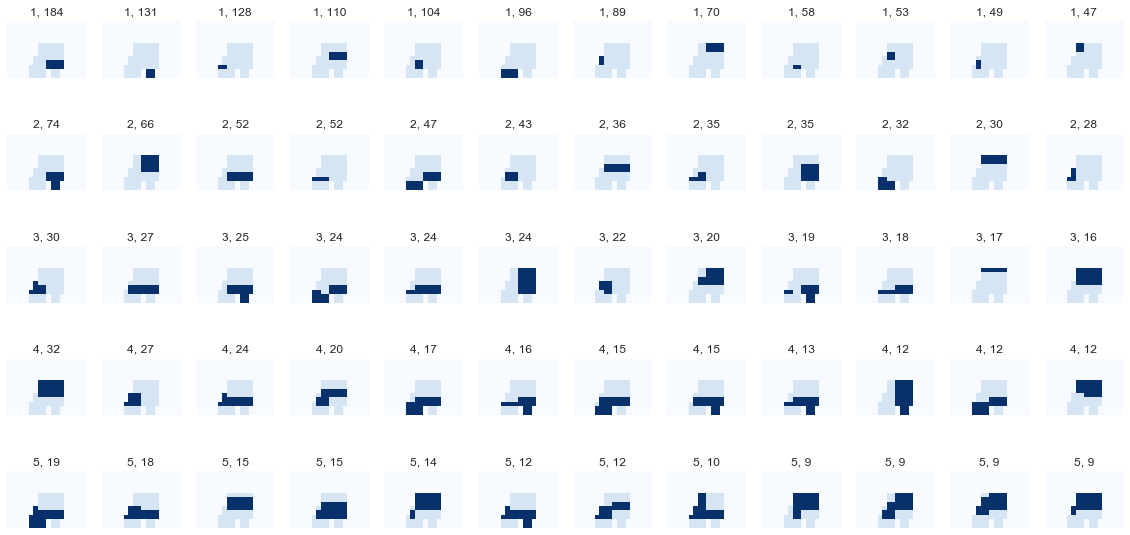

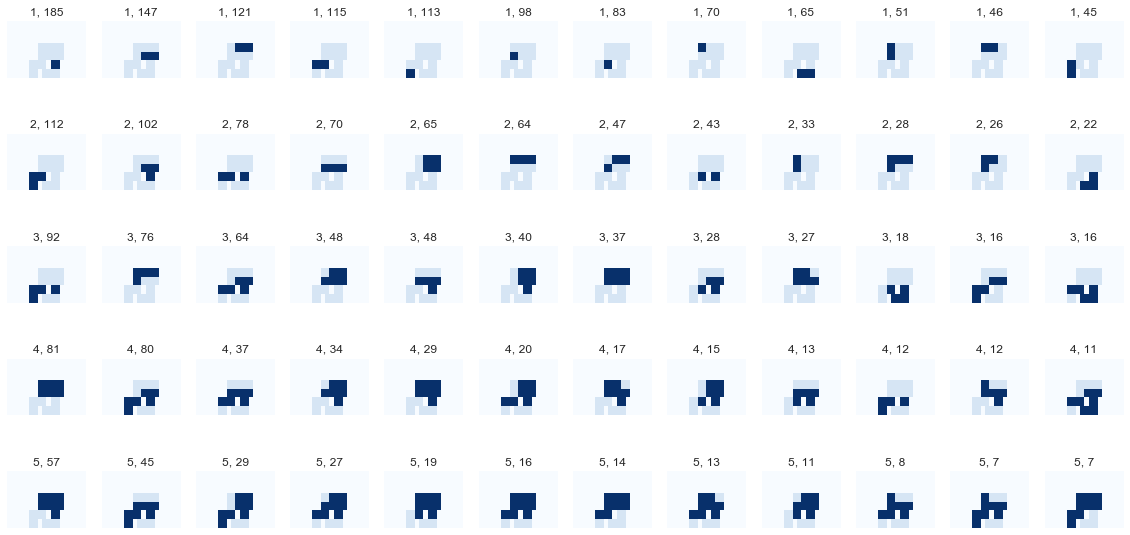

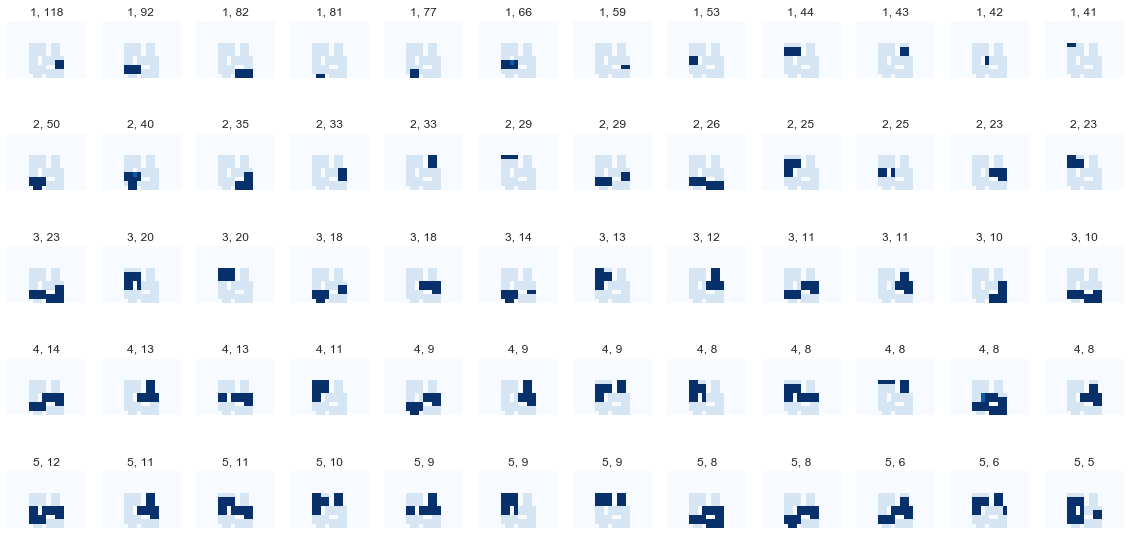

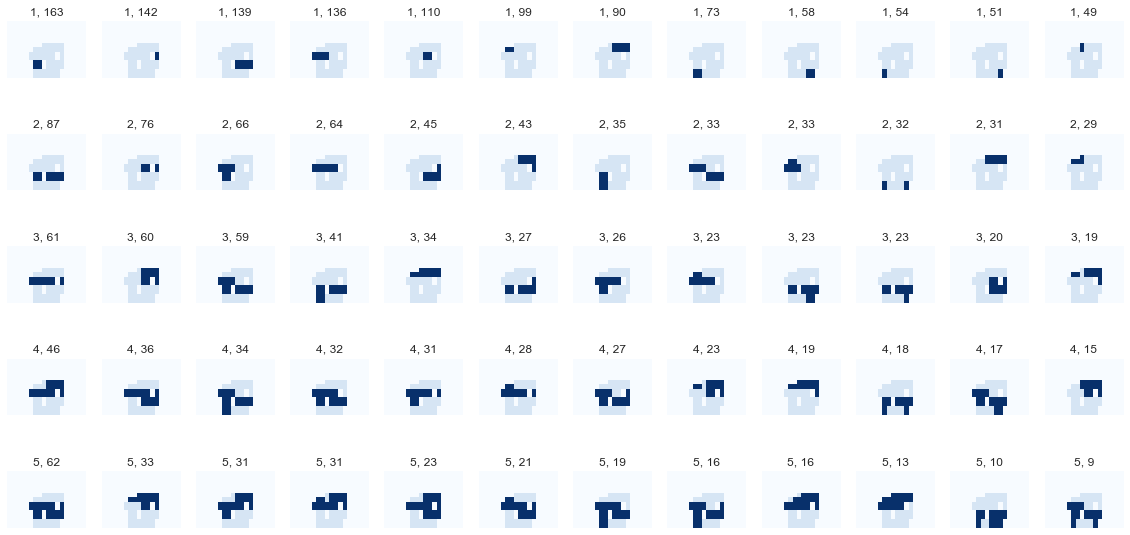

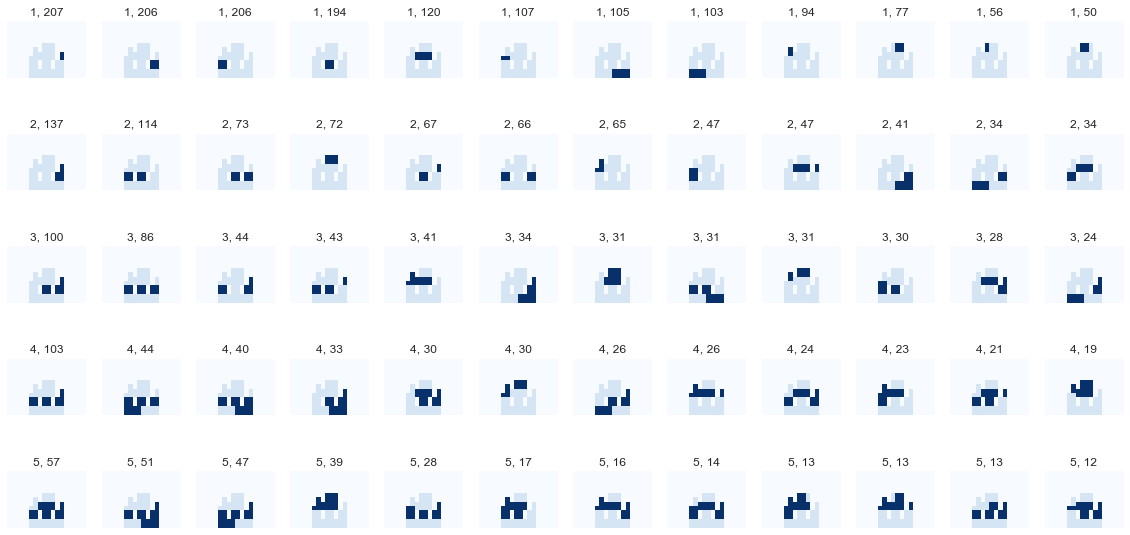

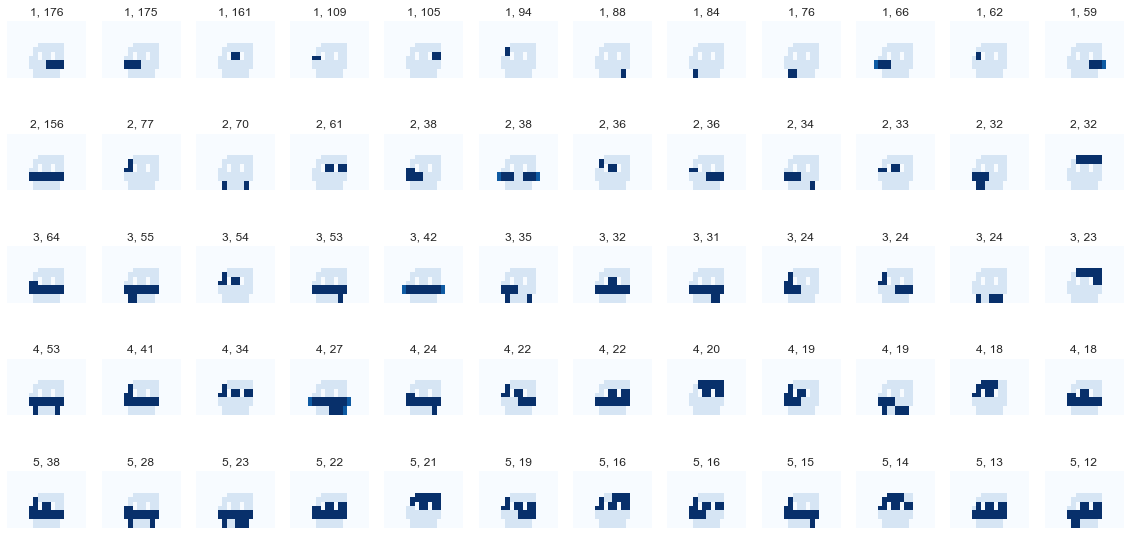

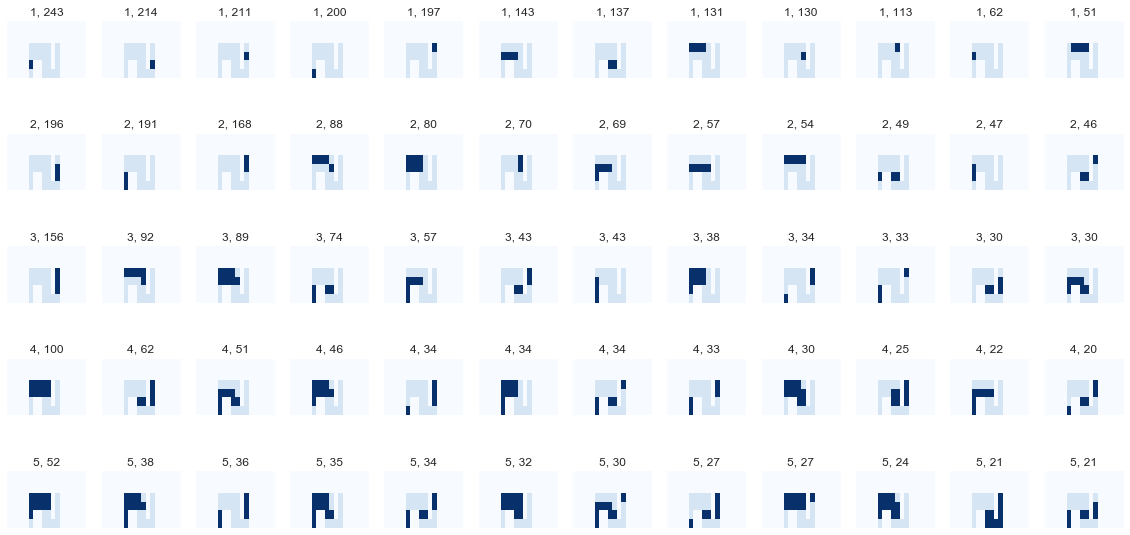

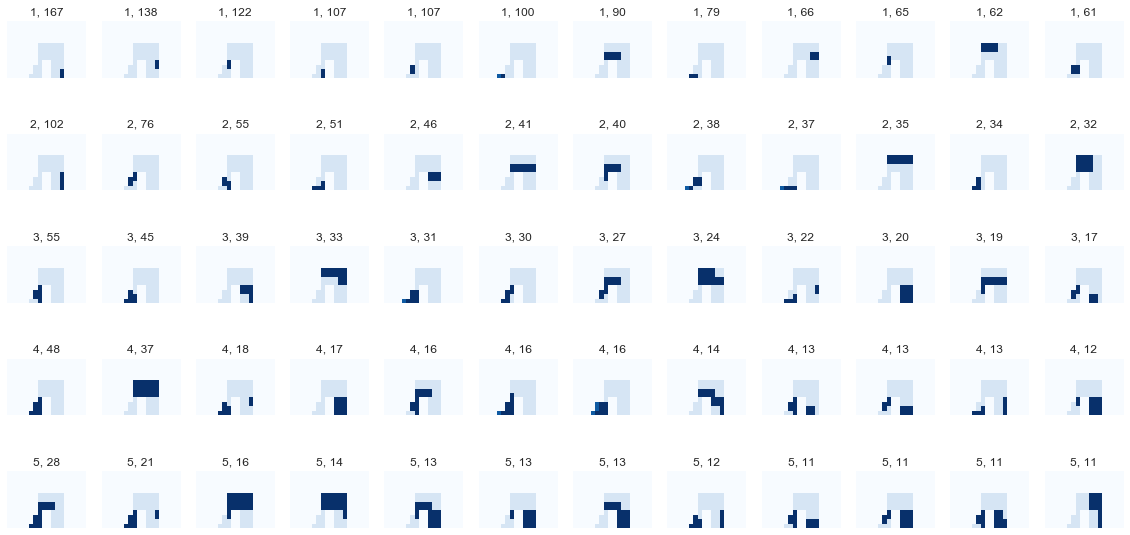

In [45]:
# visualize most popular chunks
# for each ngram, draw the sequence of world states in one image (minus the rest of the image)

for t in targets:

#     print('chunk size: ', chunk_size)
    fig, axs = plt.subplots(len(window_sizes), n_top_chunks, figsize=(20,2*len(window_sizes))) # new figure for each target

    for csi, chunk_size in enumerate(window_sizes):
        for j in range(0,n_top_chunks):
            states = [top_chunks_all[chunk_size][t]['top_k_diff'][j][0]]

            axs[csi,j].axis('off')
            axs[csi,j].set_title(str(chunk_size - 1) + ', ' + str(top_chunks_all[chunk_size][t]['top_k_diff'][j][1]))

            show_chunk(states, axs[csi,j], target=t)


### See where chunks appear most frequently

#### Compute all chunks of all lengths in all reconstructions, so we can check each reconstruction for the presence of a given chunk

In [50]:
# find all chunks for all structures (so later we can search for the structures that involve this chunk)

def compute_all_chunks(window_sizes):

    df_target_grouped = dfic.groupby(['gameID','targetName','phase_extended'])['flatDiscreteWorldStr']

    df_chunks = df.copy()

    for chunk_size in window_sizes:

        # for each reconstruction, get a list of ngrams of that length
        df_ngrams = df_target_grouped.agg(lambda ws: list(nltk.ngrams(list(ws), chunk_size))).reset_index()

        # find the chunks (world deltas) from those ngrams   
        df_ngrams['world_diff'] = df_ngrams['flatDiscreteWorldStr'].apply(lambda ngrams:
                                         ["".join([str(int(a)) for a in 
                                          list(
                                              np.logical_xor(np.array(list(ngram[-1])).astype(np.bool), 
                                              np.array(list(ngram[0])).astype(np.bool))
                                              )])
                                         for ngram in ngrams])

        df_ngrams = df_ngrams.rename(columns={"flatDiscreteWorldStr": str(chunk_size)+'_grams',
                                              "world_diff": str(chunk_size)+'_chunks'})

        df_chunks = df_chunks.merge(df_ngrams, how='left', on=['gameID','targetName','phase_extended'])
        
    return df_chunks

### leave one out analysis

In [51]:
# set vars for analysis
n_top_chunks = 12 # n most popular chunks
window_sizes = range(2,7) # how many actions are we considering? Window-size of 3 means 2 actions

In [52]:
df_chunks = compute_all_chunks(window_sizes)

In [54]:
# leave-one-out analysis. We are doing this to:
# - see whether people use more procedural chunks/options in their final attempt than in their first
# - identify the most common chunks (common to most sets)

df_chunk_use = pd.DataFrame()

for ppt_i, left_out_ppt in enumerate(ppts):
    print('leaving out ppt ' + str(ppt_i) + ' of ' + str(len(ppts)))
    # filter out one ppt
    df_without_ppt = dfic[dfic.gameID!=left_out_ppt]
    
    # get popular chunks 
    top_chunks = find_popular_chunks(df_without_ppt,
                                         window_sizes = window_sizes,
                                         n_chunks = n_top_chunks)
    
    # find statistics for these chunks in the left-out participant 
    for chunk_window in window_sizes:
        for target in targets:
            for rank in range(n_top_chunks):

                # what now? Find how many are present at the start and how many at the end?
                
                # For each chunk, record whether or not it was built by this participant
                for phase in ['pre','post']:
                    
                    chunk_item = list(top_chunks[chunk_window][target]['top_k_diff'])[rank]
                    chunk = chunk_item[0]
                    
                    n_phase_recons = df_chunks[(df_chunks.phase_extended==phase) & (df_chunks.targetName==target)].shape[0]
                    
                    # check if reconstruction does contain this chunk
                    # search for chunk in the same chunk window (avoid this if we want it to be more option-like)
                    subset_with_chunk = df_chunks[
                                            (df_chunks.gameID==left_out_ppt) &
                                            (df_chunks.targetName == target) & 
                                            (df_chunks.phase_extended == phase) &
                                            (df_chunks[str(chunk_window)+'_chunks'].apply(lambda chunks: chunk in chunks))]
                    
                    if(len(subset_with_chunk)>1):
                        print(subset_with_chunk)
                    
                    assert(len(subset_with_chunk)<=1)
                    
                    df_chunk_use = df_chunk_use.append(
                        {
                            'targetName': target,
                            'chunk_window': chunk_window,
                            'rank': rank,
                            'chunk': chunk,
                            'n_builds_in_training_set': chunk_item[1],
                            'built_by_ppt': len(subset_with_chunk) > 0,
                            'n_phase_recons': n_phase_recons,
                            'prop_containing_chunk': (len(subset_with_chunk) > 0) / n_phase_recons,
                            'phase': phase,
                            'chunk_source': 'both_phases' + '_without_' + left_out_ppt

                        },
                        ignore_index=True)

df_chunk_use_separate_phases['gameID'] = df_chunk_use_separate_phases.chunk_source.apply(lambda x: x.split('_')[2])
df_chunk_use = add_chunk_info(df_chunk_use)

leaving out ppt 0 of 105
leaving out ppt 1 of 105
leaving out ppt 2 of 105
leaving out ppt 3 of 105
leaving out ppt 4 of 105
leaving out ppt 5 of 105
leaving out ppt 6 of 105
leaving out ppt 7 of 105
leaving out ppt 8 of 105
leaving out ppt 9 of 105
leaving out ppt 10 of 105
leaving out ppt 11 of 105
leaving out ppt 12 of 105
leaving out ppt 13 of 105
leaving out ppt 14 of 105
leaving out ppt 15 of 105
leaving out ppt 16 of 105
leaving out ppt 17 of 105
leaving out ppt 18 of 105
leaving out ppt 19 of 105
leaving out ppt 20 of 105
leaving out ppt 21 of 105
leaving out ppt 22 of 105
leaving out ppt 23 of 105
leaving out ppt 24 of 105
leaving out ppt 25 of 105
leaving out ppt 26 of 105
leaving out ppt 27 of 105
leaving out ppt 28 of 105
leaving out ppt 29 of 105
leaving out ppt 30 of 105
leaving out ppt 31 of 105
leaving out ppt 32 of 105
leaving out ppt 33 of 105
leaving out ppt 34 of 105
leaving out ppt 35 of 105
leaving out ppt 36 of 105
leaving out ppt 37 of 105
leaving out ppt 38 of 

In [55]:
# pickle.dump(df_chunk_use, open("df_chunk_use_2to6.p", "wb" ))

In [ ]:
# How often were most popular chunks used in imperfect reconstructions, by phase?
# Here, each line is a chunk identified in from all perfect reconstructions (of a tower).
# They seem to be built more often in post.

fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
g = sns.FacetGrid(df_chunk_use, col="chunk_window", height=4, hue='chunk')
g.map(sns.pointplot, "phase", "prop_containing_chunk", order=['pre','post']);

### Find popular chunks in separate phases, then search for them in the same phase

In [56]:
# separate phases!

# leave-one-out analysis. We are doing this to:
# - see whether people use more procedural chunks/options in their final attempt than in their first
# - identify the most common chunks (common to most sets)

df_chunk_use_separate_phases = pd.DataFrame()

for ppt_i, left_out_ppt in enumerate(ppts):
    print('leaving out ppt ' + str(ppt_i) + ' of ' + str(len(ppts)))
    
    # find statistics for these chunks in the left-out participant 
    for phase in ['pre','post']:
        
        # filter out one ppt
        df_phase_without_ppt = dfic[(dfic.gameID!=left_out_ppt) & (dfic.phase_extended==phase)]

        # get popular chunks 
        top_chunks = find_popular_chunks(df_phase_without_ppt,
                                             window_sizes = window_sizes,
                                             n_chunks = n_top_chunks)
        
        for chunk_window in window_sizes:
            for target in targets:
                for rank in range(n_top_chunks):

                # what now? Find how many are present at the start and how many at the end?
                
                # For each chunk, record whether or not it was built by this participant
                    
                    chunk_item = list(top_chunks[chunk_window][target]['top_k_diff'])[rank]
                    chunk = chunk_item[0]
                    
                    n_phase_recons = df_chunks[(df_chunks.phase_extended==phase) & (df_chunks.targetName==target)].shape[0]
                    
                    # check if reconstruction does contain this chunk
                    # search for chunk in the same chunk window (avoid this if we want it to be more option-like)
                    subset_with_chunk = df_chunks[
                                            (df_chunks.gameID==left_out_ppt) &
                                            (df_chunks.targetName == target) & 
                                            (df_chunks.phase_extended == phase) &
                                            (df_chunks[str(chunk_window)+'_chunks'].apply(lambda chunks: chunk in chunks))]
                    
                    if(len(subset_with_chunk)>1):
                        print(subset_with_chunk)
                    
                    assert(len(subset_with_chunk)<=1)
                    
                    df_chunk_use_separate_phases = df_chunk_use_separate_phases.append(
                        {
                            'targetName': target,
                            'chunk_window': chunk_window,
                            'rank': rank,
                            'chunk': chunk,
                            'n_builds_in_training_set': chunk_item[1],
                            'built_by_ppt': len(subset_with_chunk) > 0,
                            'n_phase_recons': n_phase_recons,
                            'prop_containing_chunk': (len(subset_with_chunk) > 0) / n_phase_recons,
                            'phase': phase,
                            'chunk_source': phase + '_without_' + left_out_ppt

                        },
                        ignore_index=True)
                    
# save left out ppt                    
df_chunk_use_separate_phases['gameID'] = df_chunk_use_separate_phases.chunk_source.apply(lambda x: x.split('_')[2])
df_chunk_use_separate_phases = add_chunk_info(df_chunk_use_separate_phases)


leaving out ppt 0 of 105
leaving out ppt 1 of 105
leaving out ppt 2 of 105
leaving out ppt 3 of 105
leaving out ppt 4 of 105
leaving out ppt 5 of 105
leaving out ppt 6 of 105
leaving out ppt 7 of 105
leaving out ppt 8 of 105
leaving out ppt 9 of 105
leaving out ppt 10 of 105
leaving out ppt 11 of 105
leaving out ppt 12 of 105
leaving out ppt 13 of 105
leaving out ppt 14 of 105
leaving out ppt 15 of 105
leaving out ppt 16 of 105
leaving out ppt 17 of 105
leaving out ppt 18 of 105
leaving out ppt 19 of 105
leaving out ppt 20 of 105
leaving out ppt 21 of 105
leaving out ppt 22 of 105
leaving out ppt 23 of 105
leaving out ppt 24 of 105
leaving out ppt 25 of 105
leaving out ppt 26 of 105
leaving out ppt 27 of 105
leaving out ppt 28 of 105
leaving out ppt 29 of 105
leaving out ppt 30 of 105
leaving out ppt 31 of 105
leaving out ppt 32 of 105
leaving out ppt 33 of 105
leaving out ppt 34 of 105
leaving out ppt 35 of 105
leaving out ppt 36 of 105
leaving out ppt 37 of 105
leaving out ppt 38 of 

In [58]:
# pickle.dump(df_chunk_use_separate_phases, open("df_chunk_use_separate_phases_2to6.p", "wb" ))

In [151]:
# df_chunk_use_separate_phases = pickle.load( open( "df_chunk_use_separate_phases_2to6.p", "rb" ) )

In [66]:
# out_path = os.path.join(csv_dir,'proc_chunk_use_separate_phases_2to6.csv.csv')
# df_chunk_use_separate_phases.to_csv(out_path)

In [60]:
df_chunk_use_separate_phases['gameID'] = df_chunk_use_separate_phases.chunk_source.apply(lambda x: x.split('_')[2])

In [61]:
df_sums_separate_phases = df_chunk_use_separate_phases.groupby(['gameID','phase','targetName','chunk_window']).built_by_ppt.sum().reset_index()
df_sums_separate_phases

,gameID,phase,targetName,chunk_window,built_by_ppt
0,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,post,hand_selected_004,2.0,5.0
1,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,post,hand_selected_004,3.0,2.0
2,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,post,hand_selected_004,4.0,2.0
3,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,post,hand_selected_004,5.0,0.0
4,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,post,hand_selected_004,6.0,1.0
...,...,...,...,...,...
8395,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,pre,hand_selected_016,2.0,2.0
8396,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,pre,hand_selected_016,3.0,1.0
8397,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,pre,hand_selected_016,4.0,1.0
8398,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,pre,hand_selected_016,5.0,0.0


In [225]:
df_individual_chunk_sums = df_chunk_use_separate_phases.groupby(['gameID','phase','targetName','chunk']).built_by_ppt.sum().reset_index()
df_individual_chunk_sums


,gameID,phase,targetName,chunk,built_by_ppt
0,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,post,hand_selected_004,0000000000000000000000000000000000000000000000...,0.0
1,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,post,hand_selected_004,0000000000000000000000000000000000000000000000...,0.0
2,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,post,hand_selected_004,0000000000000000000000000000000000000000000000...,0.0
3,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,post,hand_selected_004,0000000000000000000000000000000000000000000000...,0.0
4,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,post,hand_selected_004,0000000000000000000000000000000000000000000000...,1.0
...,...,...,...,...,...
99308,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,pre,hand_selected_016,0000000000000000000000000000000000000000000000...,1.0
99309,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,pre,hand_selected_016,0000000000000000000000000000000000000000000000...,0.0
99310,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,pre,hand_selected_016,0000000000000000000000000000000000000000000000...,1.0
99311,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,pre,hand_selected_016,0000000000000000000000000000000000000000000000...,0.0


In [63]:
# out_path = os.path.join(csv_dir,'summed_proc_chunk_use_separate_phases_2to6.csv')
# df_sums_separate_phases.to_csv(out_path)

<Figure size 720x432 with 0 Axes>

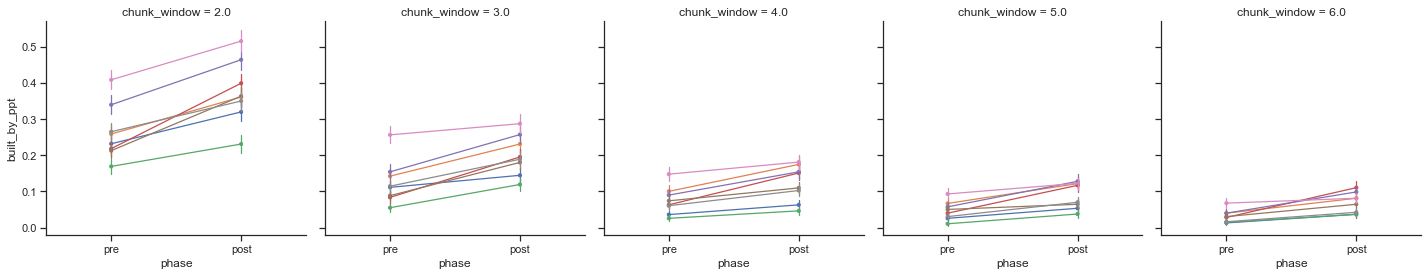

In [154]:
# How often were most popular chunks built by left-out ppt, by phase?
# by structure

fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
g = sns.FacetGrid(df_chunk_use_separate_phases, col="chunk_window", height=4, hue='targetName')
g.map(sns.pointplot, "phase", "built_by_ppt", order=['pre','post']);

<Figure size 720x432 with 0 Axes>

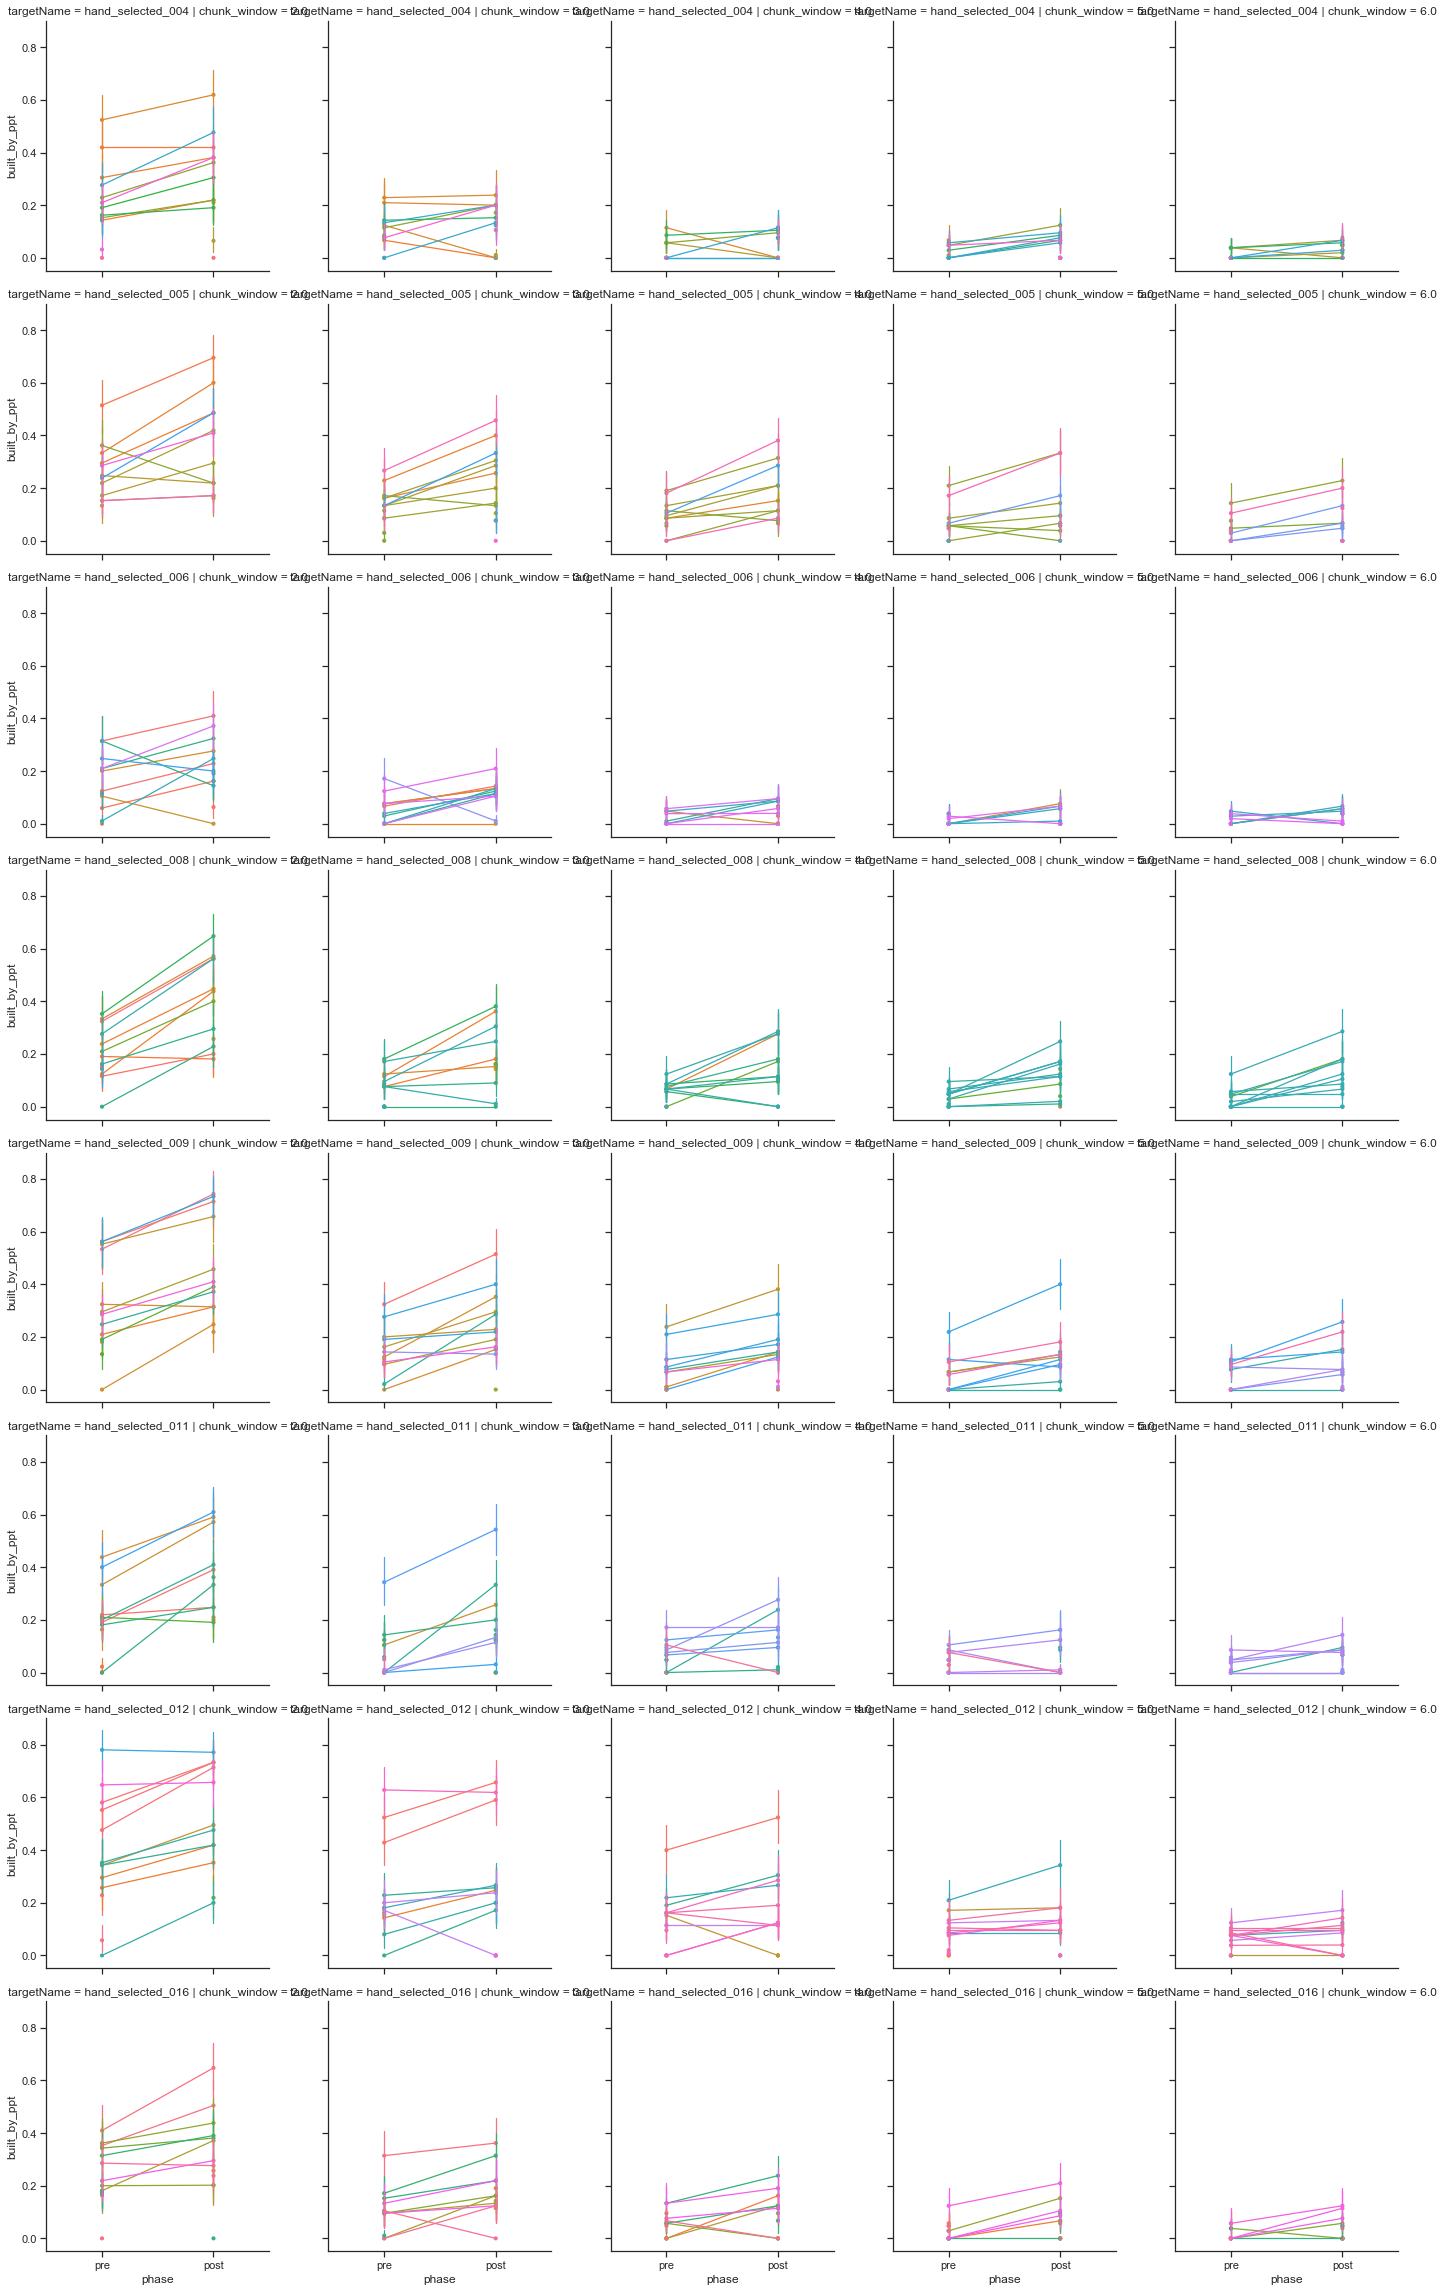

In [67]:
# How often were most popular chunks built by left-out ppt, by phase?
# by chunk

fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
g = sns.FacetGrid(df_chunk_use_separate_phases, col="chunk_window", row="targetName", height=4, hue='chunk')
g.map(sns.pointplot, "phase", "built_by_ppt", order=['pre','post']);

#### Same analysis with perfect reconstructions only

In [146]:
# leave-one-out analysis. We are doing this to:
# - see whether people use more procedural chunks/options in their final attempt than in their first
# - identify the most common chunks (common to most sets)

df_chunk_use_separate_phases_perfect = pd.DataFrame()

for ppt_i, left_out_ppt in enumerate(ppts):
    print('leaving out ppt ' + str(ppt_i) + ' of ' + str(len(ppts)))
    
    # find statistics for these chunks in the left-out participant 
    for phase in ['pre','post']:
        
        # filter out one ppt
        df_phase_without_ppt = dfic[(dfic.gameID!=left_out_ppt) & 
                                    (dfic.phase_extended==phase) & 
                                    (dfic.perfectScore)]

        # get popular chunks 
        top_chunks = find_popular_chunks(df_phase_without_ppt,
                                             window_sizes = window_sizes,
                                             n_chunks = n_top_chunks)
        
        for chunk_window in window_sizes:
            for target in targets:
                for rank in range(n_top_chunks):

                # what now? Find how many are present at the start and how many at the end?
                
                # For each chunk, record whether or not it was built by this participant
                    
                    chunk_item = list(top_chunks[chunk_window][target]['top_k_diff'])[rank]
                    chunk = chunk_item[0]
                    
                    n_phase_recons = df_chunks[(df_chunks.phase_extended==phase) & 
                                               (df_chunks.targetName==target) &
                                               (df_chunks.perfectScore)].shape[0]
                    
                    # check if reconstruction does contain this chunk
                    # search for chunk in the same chunk window (avoid this if we want it to be more option-like)
                    subset_with_chunk = df_chunks[
                                            (df_chunks.gameID==left_out_ppt) &
                                            (df_chunks.targetName == target) & 
                                            (df_chunks.phase_extended == phase) &
                                            (df_chunks.perfectScore) &
                                            (df_chunks[str(chunk_window)+'_chunks'].apply(lambda chunks: chunk in chunks))]
                    
                    if(len(subset_with_chunk)>1):
                        print(subset_with_chunk)
                    
                    assert(len(subset_with_chunk)<=1)
                    
                    df_chunk_use_separate_phases_perfect = df_chunk_use_separate_phases_perfect.append(
                        {
                            'targetName': target,
                            'chunk_window': chunk_window,
                            'rank': rank,
                            'chunk': chunk,
                            'n_builds_in_training_set': chunk_item[1],
                            'built_by_ppt': len(subset_with_chunk) > 0,
                            'n_phase_recons': n_phase_recons,
                            'prop_containing_chunk': (len(subset_with_chunk) > 0) / n_phase_recons,
                            'phase': phase,
                            'chunk_source': phase + '_without_' + left_out_ppt

                        },
                        ignore_index=True)
                    
# save left out ppt                    
df_chunk_use_separate_phases_perfect['gameID'] = df_chunk_use_separate_phases_perfect.chunk_source.apply(lambda x: x.split('_')[2])
df_chunk_use_separate_phases_perfect = add_chunk_info(df_chunk_use_separate_phases_perfect)


leaving out ppt 0 of 105
leaving out ppt 1 of 105
leaving out ppt 2 of 105
leaving out ppt 3 of 105
leaving out ppt 4 of 105
leaving out ppt 5 of 105
leaving out ppt 6 of 105
leaving out ppt 7 of 105
leaving out ppt 8 of 105
leaving out ppt 9 of 105
leaving out ppt 10 of 105
leaving out ppt 11 of 105
leaving out ppt 12 of 105
leaving out ppt 13 of 105
leaving out ppt 14 of 105
leaving out ppt 15 of 105
leaving out ppt 16 of 105
leaving out ppt 17 of 105
leaving out ppt 18 of 105
leaving out ppt 19 of 105
leaving out ppt 20 of 105
leaving out ppt 21 of 105
leaving out ppt 22 of 105
leaving out ppt 23 of 105
leaving out ppt 24 of 105
leaving out ppt 25 of 105
leaving out ppt 26 of 105
leaving out ppt 27 of 105
leaving out ppt 28 of 105
leaving out ppt 29 of 105
leaving out ppt 30 of 105
leaving out ppt 31 of 105
leaving out ppt 32 of 105
leaving out ppt 33 of 105
leaving out ppt 34 of 105
leaving out ppt 35 of 105
leaving out ppt 36 of 105
leaving out ppt 37 of 105
leaving out ppt 38 of 

In [328]:
# df_chunk_use_separate_phases_perfect = add_chunk_info(df_chunk_use_separate_phases_perfect)

In [ ]:
#pickle.load(df_chunk_use_separate_phases_perfect, open("df_chunk_use_separate_phases_2to6_perfect.p", "rb" ))

In [330]:
#pickle.dump(df_chunk_use_separate_phases, open("df_chunk_use_separate_phases_2to6.p", "wb" ))

In [331]:
# out_path = os.path.join(csv_dir,'proc_chunk_use_separate_phases_2to6_perc_counts.csv')
# df_chunk_use_separate_phases.to_csv(out_path)

In [152]:
# df_sums_perfect = df_chunk_use_separate_phases_perfect.groupby(['gameID','phase','targetName','chunk_window']).built_by_ppt.sum().reset_index()
# df_sums_perfect

In [150]:
# out_path = os.path.join(csv_dir,'summed_proc_chunk_use_separate_phases_2to6_perfect.csv')
# df_sums_perfect.to_csv(out_path)

In [332]:
# How often were most popular chunks built by left-out ppt, by phase?
# by structure

fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
g = sns.FacetGrid(df_chunk_use_separate_phases_perfect, col="chunk_window", height=4, hue='targetName')
g.map(sns.pointplot, "phase", "built_by_ppt", order=['pre','post']);

df_chunk_use_separate_phases

,built_by_ppt,chunk,chunk_source,chunk_window,n_builds_in_training_set,n_phase_recons,phase,prop_containing_chunk,rank,targetName,gameID,perceptual_count,height,area
0,1.0,0000000000000000000000000000000000000000000000...,pre_without_0050-6c4598b0-4ba2-453b-9450-a2b56...,2.0,54.0,105.0,pre,0.009524,0.0,hand_selected_004,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,0,3.000000,8
1,0.0,0000000000000000000000000000000000000000000000...,pre_without_0050-6c4598b0-4ba2-453b-9450-a2b56...,2.0,44.0,105.0,pre,0.000000,1.0,hand_selected_004,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,40,1.000000,4
2,0.0,0000000000000000000000000000000000000000000000...,pre_without_0050-6c4598b0-4ba2-453b-9450-a2b56...,2.0,32.0,105.0,pre,0.000000,2.0,hand_selected_004,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,1,5.000000,8
3,1.0,0000000000000000000000000000000000000000000000...,pre_without_0050-6c4598b0-4ba2-453b-9450-a2b56...,2.0,28.0,105.0,pre,0.009524,3.0,hand_selected_004,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,0,2.500000,2
4,1.0,0000000000000000000000000000000000000000000000...,pre_without_0050-6c4598b0-4ba2-453b-9450-a2b56...,2.0,23.0,105.0,pre,0.009524,4.0,hand_selected_004,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,1,3.000000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100795,0.0,0000000000000000000000000000000000000000000000...,post_without_9995-aa7dd1d6-ff3f-41e8-ade6-da41...,6.0,5.0,105.0,post,0.000000,7.0,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,0,4.000000,18
100796,0.0,0000000000000000000000000000000000000000000000...,post_without_9995-aa7dd1d6-ff3f-41e8-ade6-da41...,6.0,5.0,105.0,post,0.000000,8.0,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,0,2.142857,14
100797,0.0,0000000000000000000000000000000000000000000000...,post_without_9995-aa7dd1d6-ff3f-41e8-ade6-da41...,6.0,4.0,105.0,post,0.000000,9.0,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,0,1.500000,12
100798,0.0,0000000000000000000000000000000000000000000000...,post_without_9995-aa7dd1d6-ff3f-41e8-ade6-da41...,6.0,4.0,105.0,post,0.000000,10.0,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,0,4.000000,20


<Figure size 720x432 with 0 Axes>

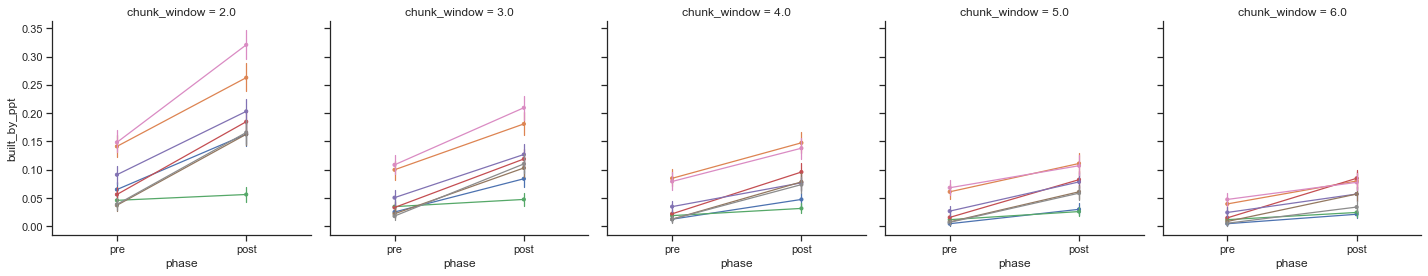

In [155]:
# How often were most popular chunks built by left-out ppt, by phase?
# by structure

fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
g = sns.FacetGrid(df_chunk_use_separate_phases_perfect, col="chunk_window", height=4, hue='targetName')
g.map(sns.pointplot, "phase", "built_by_ppt", order=['pre','post']);

<Figure size 720x432 with 0 Axes>

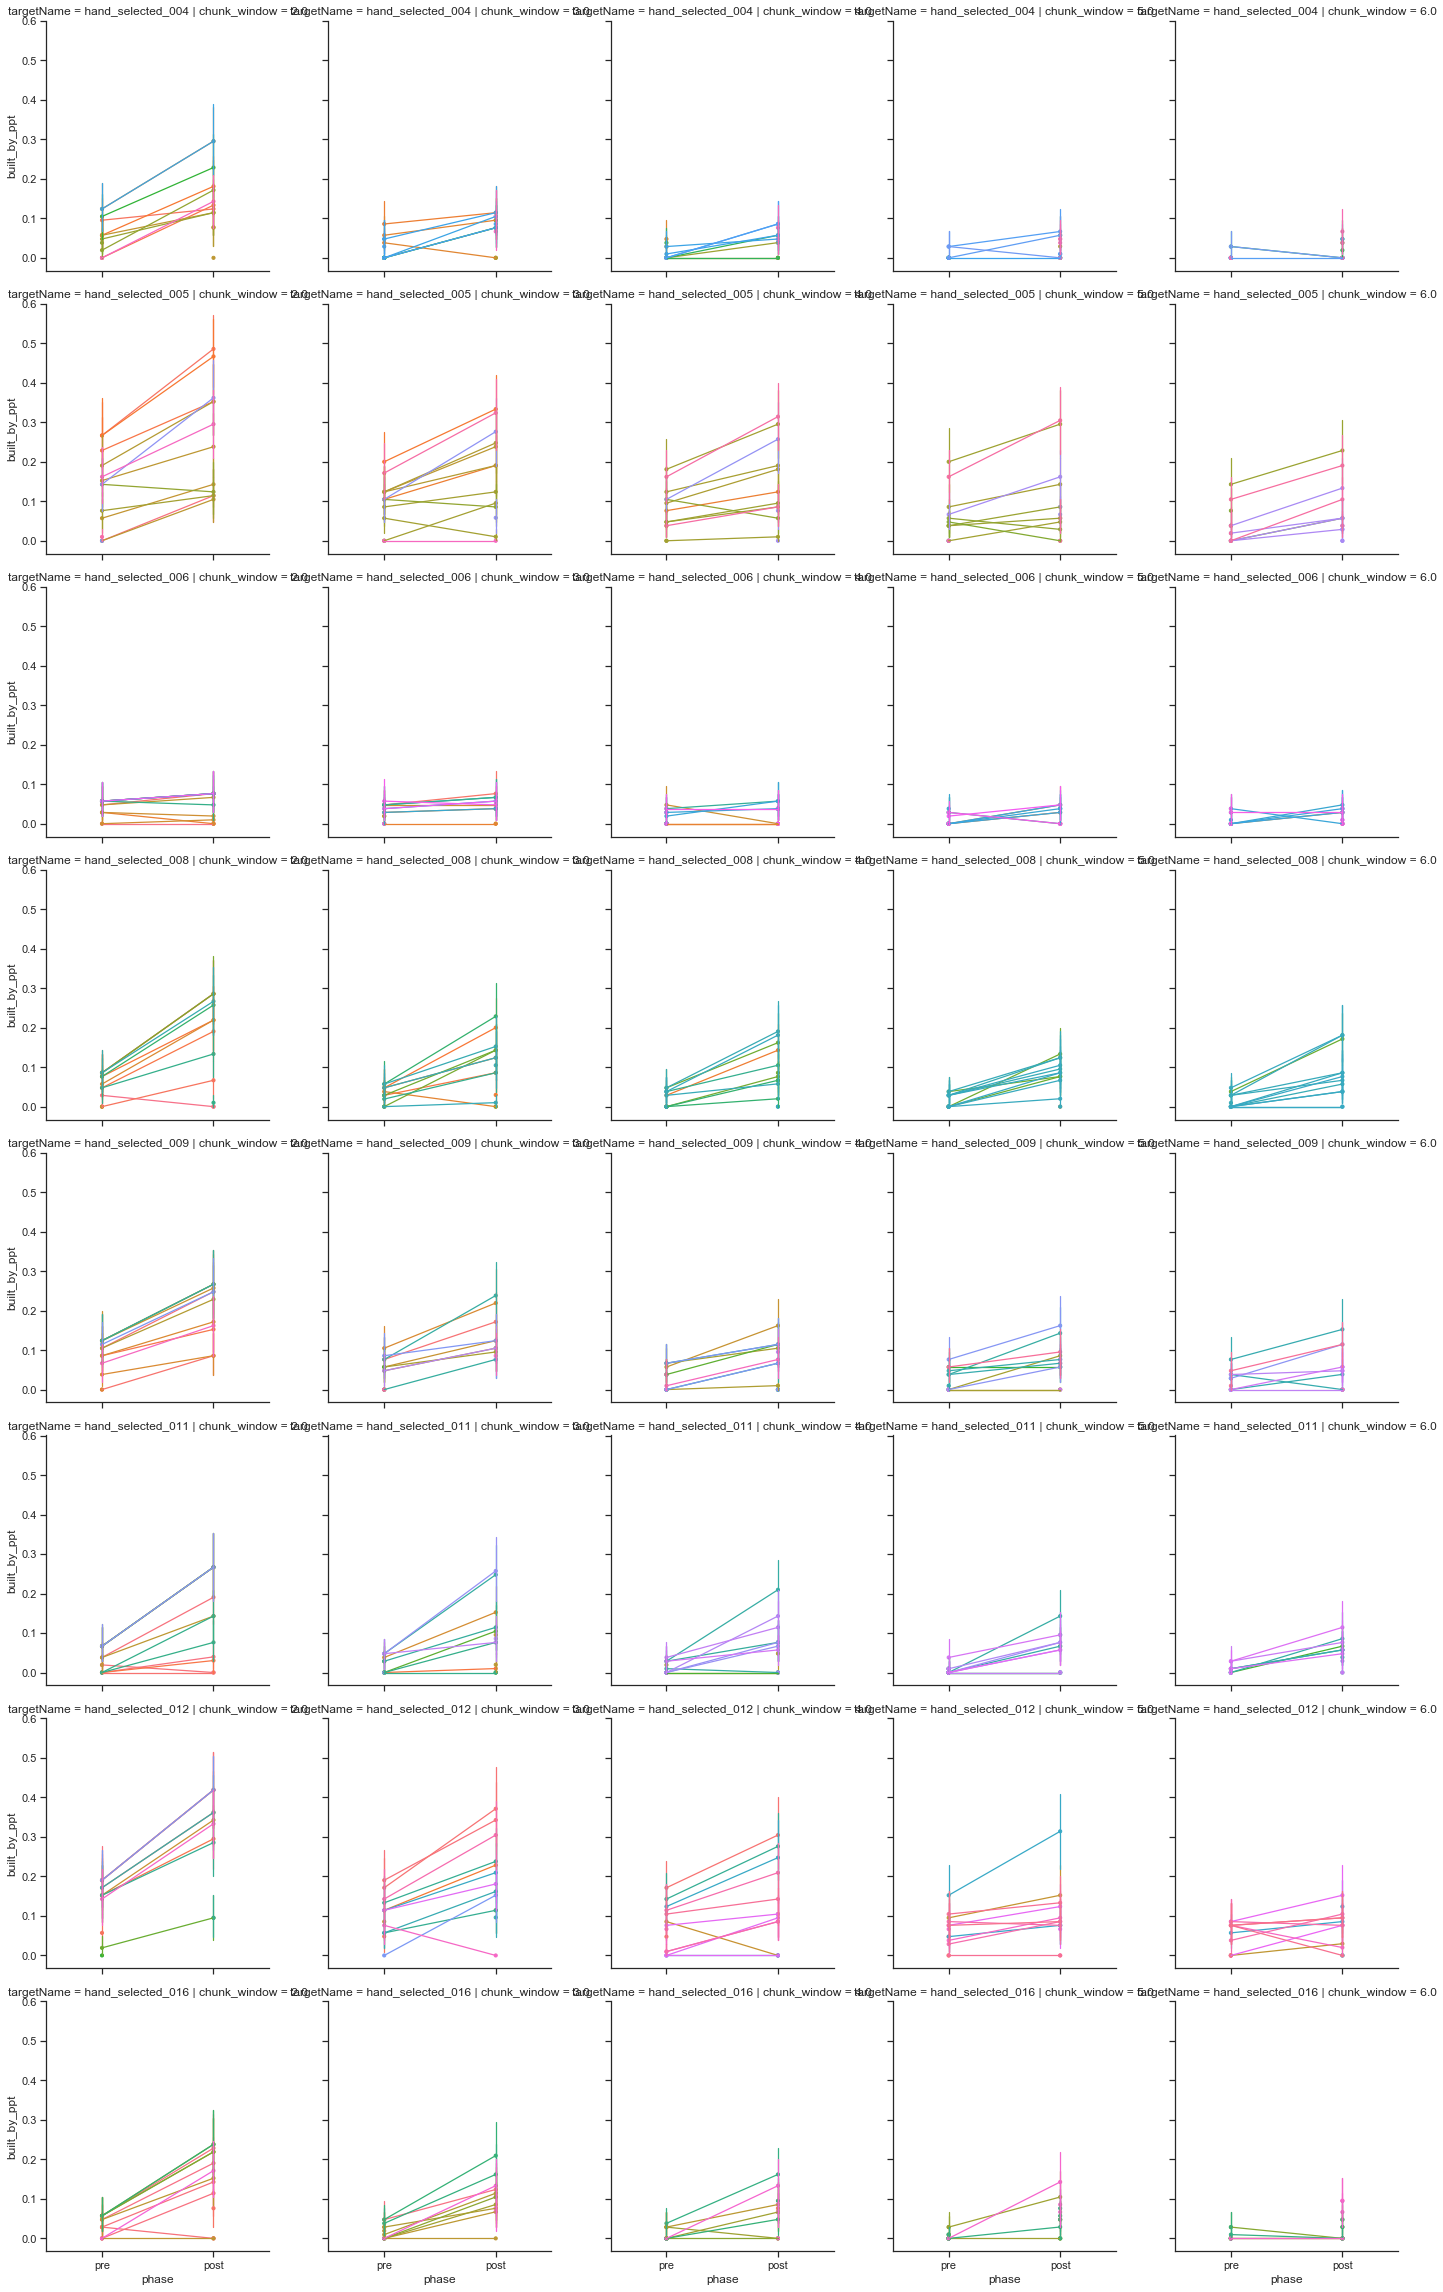

In [156]:
# How often were most popular chunks built by left-out ppt, by phase?
# by chunk

fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
g = sns.FacetGrid(df_chunk_use_separate_phases_perfect, col="chunk_window", row="targetName", height=4, hue='chunk')
g.map(sns.pointplot, "phase", "built_by_ppt", order=['pre','post']);

## Other analyses

### Top movers first to final attempt

In [69]:
def get_diff(rows):
    print(rows)
    post = rows[rows.phase=='post']
    pre = rows[rows.phase=='pre']
    assert len(post)<2
    assert len(pre)<2

    if (len(post)==1)&(len(pre)==1):
        return post.built_by_ppt[0] - pre.built_by_ppt[0]
    elif len(post)==1:
        return post.built_by_ppt[0]
    else:
        return -pre.built_by_ppt[0]
        

In [ ]:
# use mean amount of reconstructions (because structures can appear a different number of times)

In [228]:
df_top_movers_mean = df_chunk_use_separate_phases.groupby(['chunk','phase','targetName','chunk_window']).built_by_ppt.mean().reset_index()
df_top_movers_mean = add_chunk_info(df_top_movers_mean)
df_top_movers_mean

,chunk,phase,targetName,chunk_window,built_by_ppt
0,0000000000000000000000000000000000000000000000...,post,hand_selected_008,2.0,0.561905
1,0000000000000000000000000000000000000000000000...,post,hand_selected_009,2.0,0.742857
2,0000000000000000000000000000000000000000000000...,pre,hand_selected_008,2.0,0.323810
3,0000000000000000000000000000000000000000000000...,pre,hand_selected_009,2.0,0.533333
4,0000000000000000000000000000000000000000000000...,pre,hand_selected_012,2.0,0.057471
...,...,...,...,...,...
1087,0000000000000000000000000000000000000000000000...,post,hand_selected_016,6.0,0.000000
1088,0000000000000000000000000000000000000000000000...,pre,hand_selected_016,5.0,0.047619
1089,0000000000000000000000000000000000000000000000...,pre,hand_selected_016,6.0,0.000000
1090,0000000000000000000000000000000000000000000000...,post,hand_selected_016,5.0,0.000000


In [229]:
#trying to find difference between pre and post here, to identify biggest movers:
df_proc_diff_mean = df_top_movers_mean.pivot(index=['targetName','chunk_window','chunk'], columns="phase", values="built_by_ppt").fillna(0)
df_proc_diff_mean['diff'] = df_proc_diff_mean['post'] - df_proc_diff_mean['pre']
df_proc_diff_mean = df_proc_diff_mean.reset_index()
df_proc_diff_mean

phase,targetName,chunk_window,chunk,post,pre,diff
0,hand_selected_004,2.0,0000000000000000000000000000000000000000000000...,0.000000,0.000000,0.000000
1,hand_selected_004,2.0,0000000000000000000000000000000000000000000000...,0.000000,0.000000,0.000000
2,hand_selected_004,2.0,0000000000000000000000000000000000000000000000...,0.419048,0.419048,0.000000
3,hand_selected_004,2.0,0000000000000000000000000000000000000000000000...,0.219048,0.142857,0.076190
4,hand_selected_004,2.0,0000000000000000000000000000000000000000000000...,0.380952,0.304762,0.076190
...,...,...,...,...,...,...
734,hand_selected_016,6.0,0000000000000000000000000000000000000000000000...,0.000000,0.000000,0.000000
735,hand_selected_016,6.0,0000000000000000000000000000000000000000000000...,0.123810,0.057143,0.066667
736,hand_selected_016,6.0,0000000000000000000000000000000000000000000000...,0.000000,0.000000,0.000000
737,hand_selected_016,6.0,0000000000000000000000000000000000000000000000...,0.000000,0.000000,0.000000


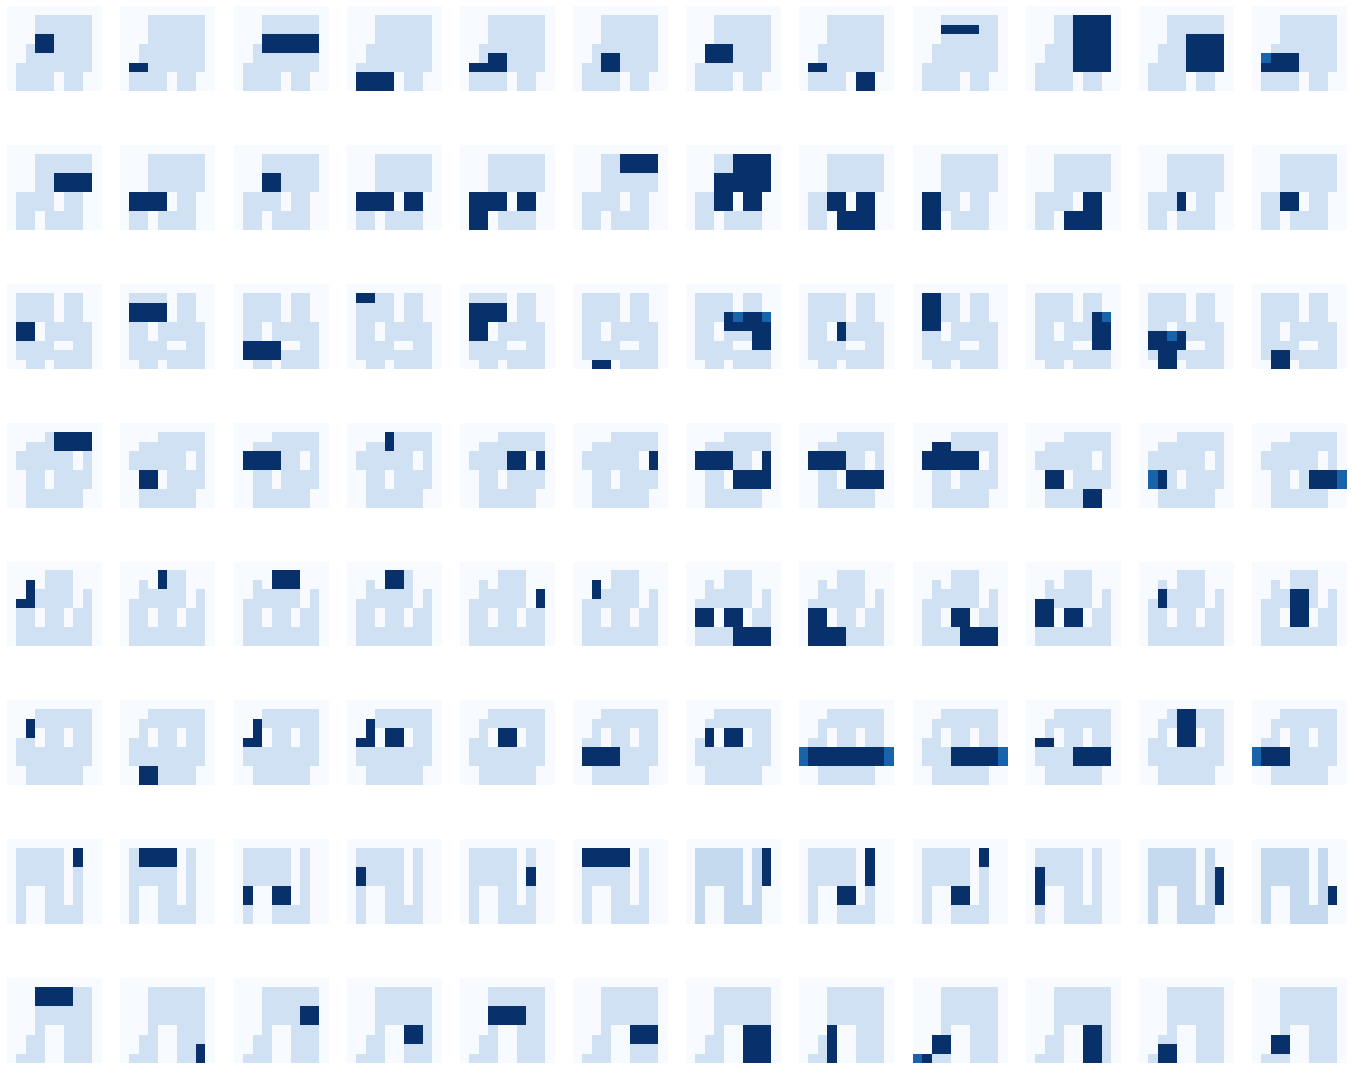

In [230]:
n_chunks = 6

fig, axs = plt.subplots(len(targets), n_chunks*2, figsize=(4*n_chunks,2.5*len(targets)))

for i, target in enumerate(targets):
    for j in range(0, n_chunks):    
        greatest_increase = df_proc_diff_mean[df_proc_diff_mean.targetName==target].sort_values('diff', ascending=False).reset_index()
        # do something graphically with: greatest_increase.loc[j,'diff']
        axs[i,j].axis('off')
        drawing.show_chunk([greatest_increase.loc[j,'chunk']], axs[i,j], target=target, cmap='Blues', cropped=True)

for i, target in enumerate(targets):
    for j in range(0, n_chunks):    
        greatest_increase = df_proc_diff_mean[df_proc_diff_mean.targetName==target].sort_values('diff', ascending=True).reset_index()
        # do something graphically with: greatest_increase.loc[j,'diff']
        axs[i,n_chunks*2-1-j].axis('off')
        drawing.show_chunk([greatest_increase.loc[j,'chunk']], axs[i,n_chunks*2-1-j], target=target, cmap='Blues', cropped=True)

# <-- Largest increase first to final ... Largest decrease first to final-->

### Integrate perceptual chunk info

In [200]:
# load dictionary of dictionaries- target: chunk: count
perceptual_chunk_counters = pickle.load(open("perceptual_chunk_counters.p", "rb" ))

def check_chunk(chunk, target, perceptual_chunk_counters):
    if chunk in perceptual_chunk_counters[target].keys():
        perceptual_count = perceptual_chunk_counters[target][chunk]
    else:
        perceptual_count = 0
    return perceptual_count
    
def add_perceptual_chunk_info(df):
    df['perceptual_count'] = df.apply(lambda row: check_chunk(row['chunk'], row['targetName'], perceptual_chunk_counters), axis=1)
    

In [ ]:
# load dataframe, add perc info, and save

df_name = 'df_name'

if False:
    df = pickle.load(open(df_name+".p", "rb" ))

    add_perceptual_chunk_info(df)

    pickle.dump(df_name, open(df_name+"_perc_counts"+".p", "wb" ))

    out_path = os.path.join(csv_dir, df_name + "_perc_counts"+".csv")
    df.to_csv(out_path)

In [334]:
df_top_movers_mean

,chunk,phase,targetName,chunk_window,built_by_ppt,height,area
0,0000000000000000000000000000000000000000000000...,post,hand_selected_008,2.0,0.561905,5.000000,2
1,0000000000000000000000000000000000000000000000...,post,hand_selected_009,2.0,0.742857,5.000000,2
2,0000000000000000000000000000000000000000000000...,pre,hand_selected_008,2.0,0.323810,5.000000,2
3,0000000000000000000000000000000000000000000000...,pre,hand_selected_009,2.0,0.533333,5.000000,2
4,0000000000000000000000000000000000000000000000...,pre,hand_selected_012,2.0,0.057471,5.000000,2
...,...,...,...,...,...,...,...
1087,0000000000000000000000000000000000000000000000...,post,hand_selected_016,6.0,0.000000,1.590909,12
1088,0000000000000000000000000000000000000000000000...,pre,hand_selected_016,5.0,0.047619,1.944444,10
1089,0000000000000000000000000000000000000000000000...,pre,hand_selected_016,6.0,0.000000,2.863636,12
1090,0000000000000000000000000000000000000000000000...,post,hand_selected_016,5.0,0.000000,1.500000,10


### Properties of popular chunks

In [ ]:
# are higher up chunks built more frequently in post than in pre?

In [ ]:
fig = plt.figure(figsize=(12,8))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
sns.scatterplot(data=a, y='height', x='built_by_ppt', hue='phase')#, dodge=True, size=8, alpha=0.5)

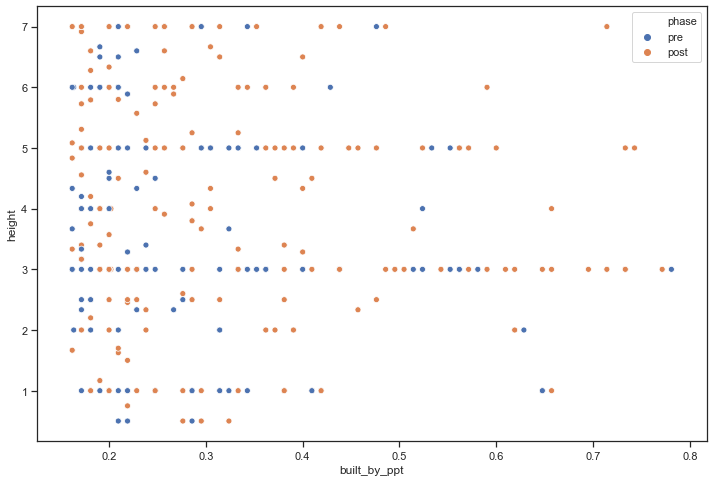

In [373]:
fig = plt.figure(figsize=(12,8))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
sns.scatterplot(data=a, y='height', x='built_by_ppt', hue='phase')#, dodge=True, size=8, alpha=0.5)

In [375]:
a = df_top_movers_mean.sort_values('built_by_ppt', ascending=False).reset_index().iloc[:200,:]

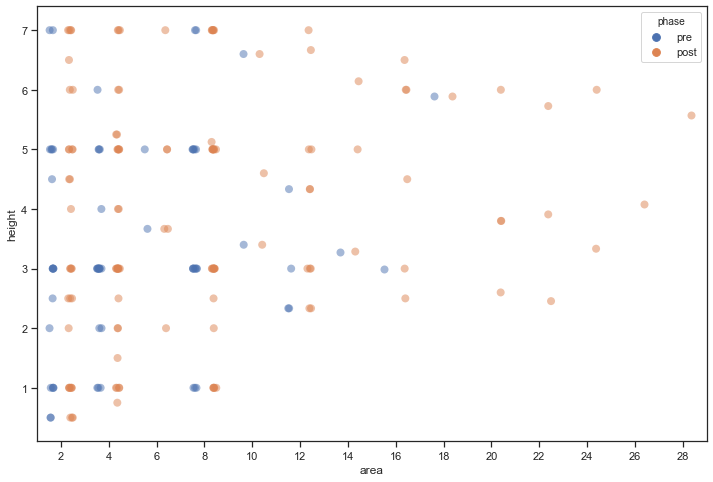

In [376]:
fig = plt.figure(figsize=(12,8))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
sns.stripplot(data=a, x='area', y='height', hue='phase', dodge=True, size=8, alpha=0.5)

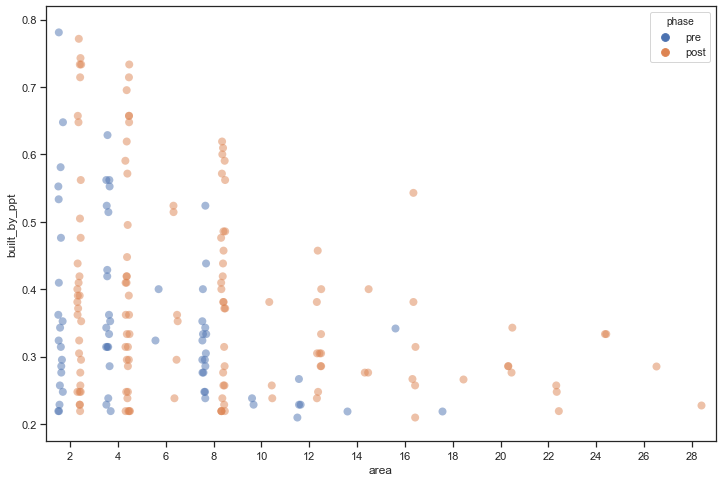

In [382]:
fig = plt.figure(figsize=(12,8))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
sns.stripplot(data=a, x='area', y='built_by_ppt', hue='phase', dodge=True, size=8, alpha=0.5)

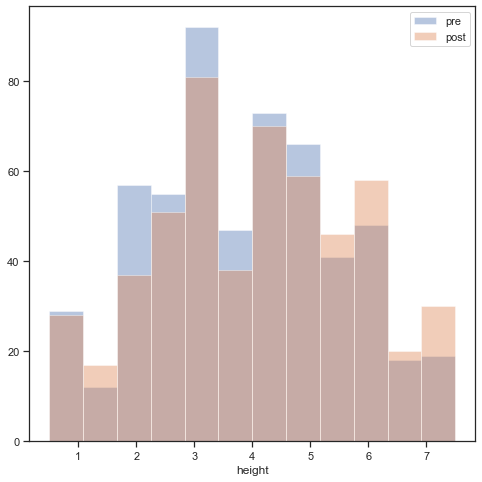

In [316]:
fig = plt.figure(figsize=(8,8))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 1.5})
sns.distplot(df_top_movers_mean[df_top_movers_mean.phase=='pre'].height, kde=False)
sns.distplot(df_top_movers_mean[df_top_movers_mean.phase=='post'].height, kde=False)
plt.legend(['pre','post'])

In [333]:
df_chunk_use_separate_phases

,built_by_ppt,chunk,chunk_source,chunk_window,n_builds_in_training_set,n_phase_recons,phase,prop_containing_chunk,rank,targetName,gameID,perceptual_count,height,area
0,1.0,0000000000000000000000000000000000000000000000...,pre_without_0050-6c4598b0-4ba2-453b-9450-a2b56...,2.0,54.0,105.0,pre,0.009524,0.0,hand_selected_004,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,0,3.000000,8
1,0.0,0000000000000000000000000000000000000000000000...,pre_without_0050-6c4598b0-4ba2-453b-9450-a2b56...,2.0,44.0,105.0,pre,0.000000,1.0,hand_selected_004,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,40,1.000000,4
2,0.0,0000000000000000000000000000000000000000000000...,pre_without_0050-6c4598b0-4ba2-453b-9450-a2b56...,2.0,32.0,105.0,pre,0.000000,2.0,hand_selected_004,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,1,5.000000,8
3,1.0,0000000000000000000000000000000000000000000000...,pre_without_0050-6c4598b0-4ba2-453b-9450-a2b56...,2.0,28.0,105.0,pre,0.009524,3.0,hand_selected_004,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,0,2.500000,2
4,1.0,0000000000000000000000000000000000000000000000...,pre_without_0050-6c4598b0-4ba2-453b-9450-a2b56...,2.0,23.0,105.0,pre,0.009524,4.0,hand_selected_004,0050-6c4598b0-4ba2-453b-9450-a2b56232ac90,1,3.000000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100795,0.0,0000000000000000000000000000000000000000000000...,post_without_9995-aa7dd1d6-ff3f-41e8-ade6-da41...,6.0,5.0,105.0,post,0.000000,7.0,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,0,4.000000,18
100796,0.0,0000000000000000000000000000000000000000000000...,post_without_9995-aa7dd1d6-ff3f-41e8-ade6-da41...,6.0,5.0,105.0,post,0.000000,8.0,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,0,2.142857,14
100797,0.0,0000000000000000000000000000000000000000000000...,post_without_9995-aa7dd1d6-ff3f-41e8-ade6-da41...,6.0,4.0,105.0,post,0.000000,9.0,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,0,1.500000,12
100798,0.0,0000000000000000000000000000000000000000000000...,post_without_9995-aa7dd1d6-ff3f-41e8-ade6-da41...,6.0,4.0,105.0,post,0.000000,10.0,hand_selected_016,9995-aa7dd1d6-ff3f-41e8-ade6-da416e7366c3,0,4.000000,20


In [249]:
importlib.reload(bc)

<module 'block_construction_helpers' from '../utils/block_construction_helpers.py'>

## left over code

In [83]:
df_top_movers = df_chunk_use_separate_phases.groupby(['chunk','phase','targetName','chunk_window']).built_by_ppt.sum().reset_index()
df_top_movers

,chunk,phase,targetName,chunk_window,built_by_ppt
0,0000000000000000000000000000000000000000000000...,post,hand_selected_008,2.0,59.0
1,0000000000000000000000000000000000000000000000...,post,hand_selected_009,2.0,78.0
2,0000000000000000000000000000000000000000000000...,pre,hand_selected_008,2.0,34.0
3,0000000000000000000000000000000000000000000000...,pre,hand_selected_009,2.0,56.0
4,0000000000000000000000000000000000000000000000...,pre,hand_selected_012,2.0,5.0
...,...,...,...,...,...
1087,0000000000000000000000000000000000000000000000...,post,hand_selected_016,6.0,0.0
1088,0000000000000000000000000000000000000000000000...,pre,hand_selected_016,5.0,5.0
1089,0000000000000000000000000000000000000000000000...,pre,hand_selected_016,6.0,0.0
1090,0000000000000000000000000000000000000000000000...,post,hand_selected_016,5.0,0.0


In [87]:
#trying to find difference between pre and post here, to identify biggest movers:
df_proc_diff = df_top_movers.pivot(index=['targetName','chunk_window','chunk'], columns="phase", values="built_by_ppt").fillna(0)
df_proc_diff['diff'] = df_proc_diff['post'] - df_proc_diff['pre']
df_proc_diff = df_proc_diff.reset_index()
df_proc_diff

phase,targetName,chunk_window,chunk,post,pre,diff
0,hand_selected_004,2.0,0000000000000000000000000000000000000000000000...,0.0,0.0,0.0
1,hand_selected_004,2.0,0000000000000000000000000000000000000000000000...,0.0,0.0,0.0
2,hand_selected_004,2.0,0000000000000000000000000000000000000000000000...,44.0,44.0,0.0
3,hand_selected_004,2.0,0000000000000000000000000000000000000000000000...,23.0,15.0,8.0
4,hand_selected_004,2.0,0000000000000000000000000000000000000000000000...,40.0,32.0,8.0
...,...,...,...,...,...,...
734,hand_selected_016,6.0,0000000000000000000000000000000000000000000000...,0.0,0.0,0.0
735,hand_selected_016,6.0,0000000000000000000000000000000000000000000000...,13.0,6.0,7.0
736,hand_selected_016,6.0,0000000000000000000000000000000000000000000000...,0.0,0.0,0.0
737,hand_selected_016,6.0,0000000000000000000000000000000000000000000000...,0.0,0.0,0.0


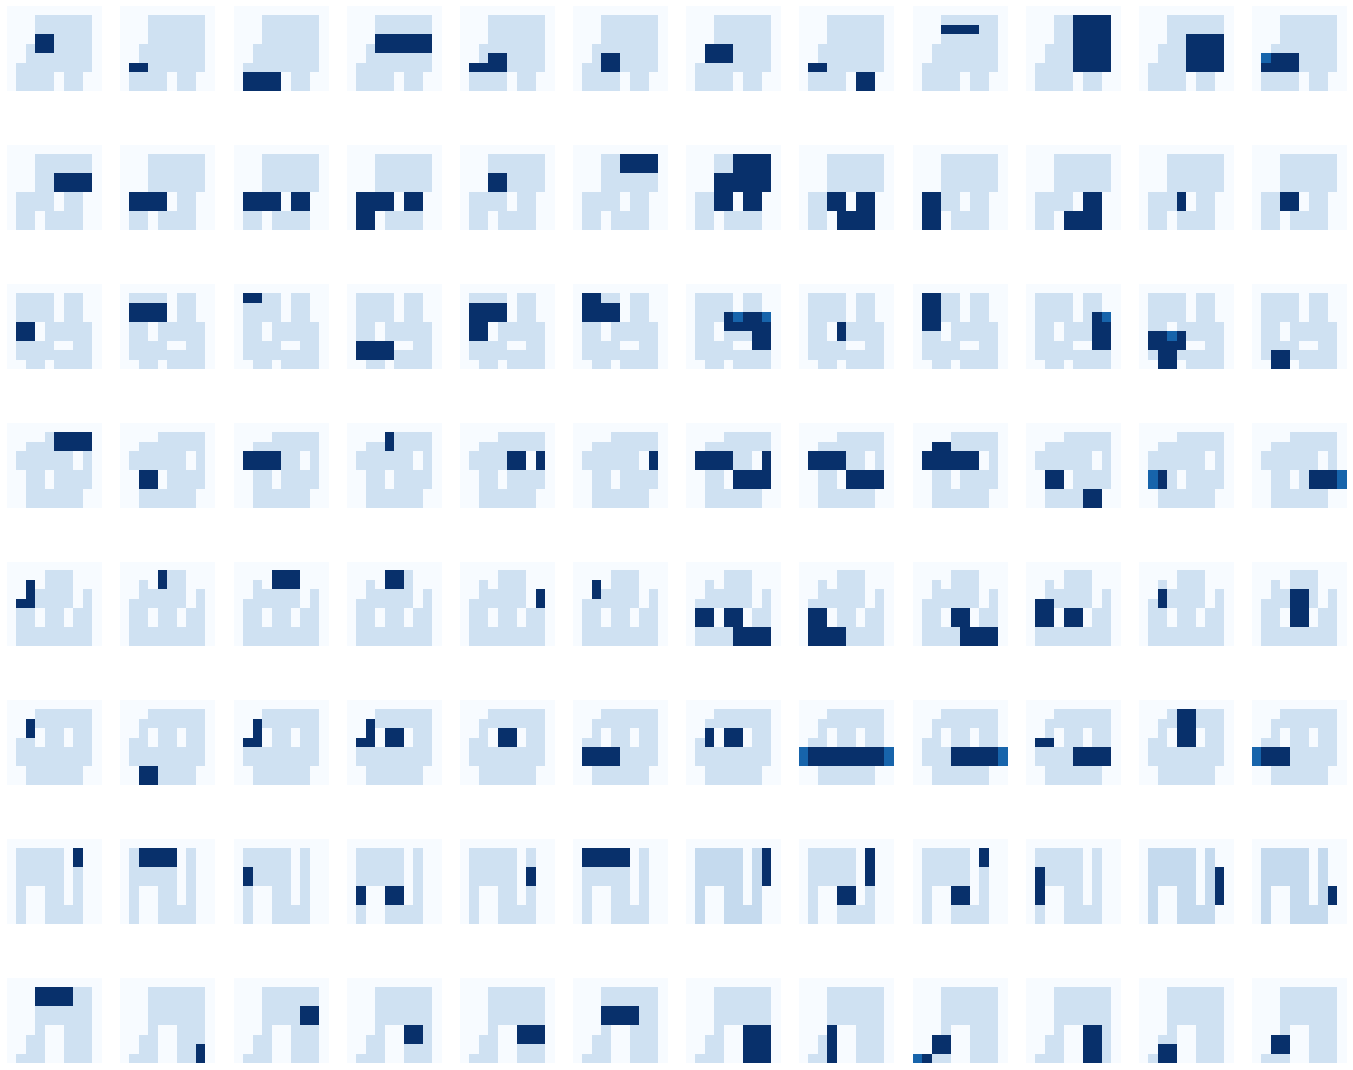

In [142]:
n_chunks = 6

fig, axs = plt.subplots(len(targets), n_chunks*2, figsize=(4*n_chunks,2.5*len(targets)))

for i, target in enumerate(targets):
    for j in range(0, n_chunks):    
        greatest_increase = df_proc_diff[df_proc_diff.targetName==target].sort_values('diff', ascending=False).reset_index()
        # do something graphically with: greatest_increase.loc[j,'diff']
        axs[i,j].axis('off')
        drawing.show_chunk([greatest_increase.loc[j,'chunk']], axs[i,j], target=target, cmap='Blues', cropped=True)

for i, target in enumerate(targets):
    for j in range(0, n_chunks):    
        greatest_increase = df_proc_diff[df_proc_diff.targetName==target].sort_values('diff', ascending=True).reset_index()
        # do something graphically with: greatest_increase.loc[j,'diff']
        axs[i,n_chunks*2-1-j].axis('off')
        drawing.show_chunk([greatest_increase.loc[j,'chunk']], axs[i,n_chunks*2-1-j], target=target, cmap='Blues', cropped=True)

# <-- Largest increase first to final ... Largest decrease first to final-->

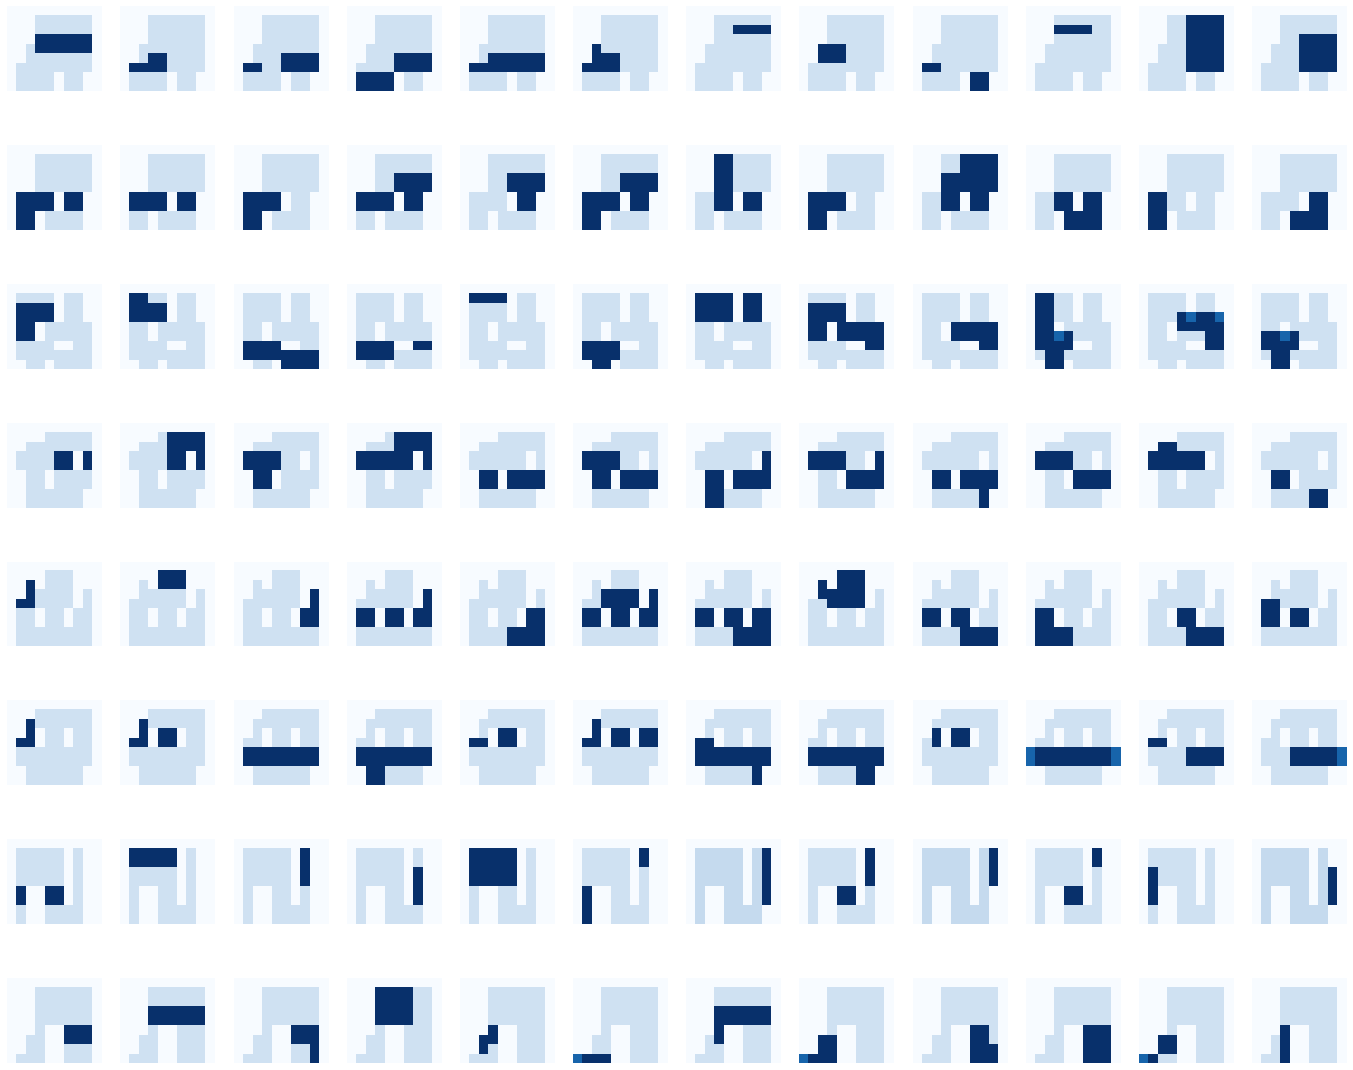

In [145]:
# Only chunks with multiple blocks

n_chunks = 6

fig, axs = plt.subplots(len(targets), n_chunks*2, figsize=(4*n_chunks,2.5*len(targets)))

for i, target in enumerate(targets):
    for j in range(0, n_chunks):    
        greatest_increase = df_proc_diff[(df_proc_diff.targetName==target) & (df_proc_diff.chunk_window>2)].sort_values('diff', ascending=False).reset_index()
        # do something graphically with: greatest_increase.loc[j,'diff']
        axs[i,j].axis('off')
        drawing.show_chunk([greatest_increase.loc[j,'chunk']], axs[i,j], target=target, cmap='Blues', cropped=True)

for i, target in enumerate(targets):
    for j in range(0, n_chunks):    
        greatest_increase = df_proc_diff[(df_proc_diff.targetName==target) & (df_proc_diff.chunk_window>2)].sort_values('diff', ascending=True).reset_index()
        # do something graphically with: greatest_increase.loc[j,'diff']
        axs[i,n_chunks*2-1-j].axis('off')
        drawing.show_chunk([greatest_increase.loc[j,'chunk']], axs[i,n_chunks*2-1-j], target=target, cmap='Blues', cropped=True)

# <-- Largest increase first to final ... Largest decrease first to final-->

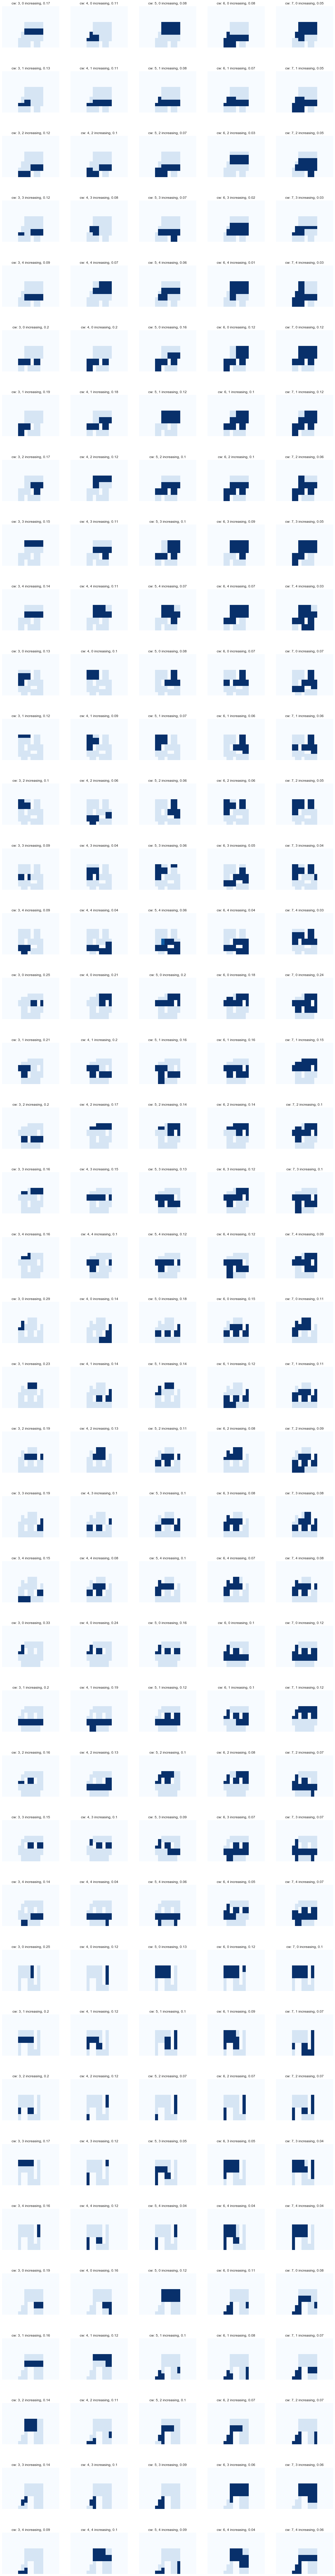

In [326]:
# plot chunks of highest increase

nchunks = 5

fig, axs = plt.subplots(len(targets)*nchunks, len(window_sizes), figsize=(4*len(window_sizes),4*len(targets)*nchunks))

for i, target in enumerate(targets):
    for j, chunk_window in enumerate(window_sizes):
        
        df_subset = df_pivot[(df_pivot.targetName==target) & (df_pivot.chunk_window==chunk_window)]
        
        #for ascending in [True, False]:
        
        df_subset_sorted = df_subset.sort_values(by='diff', ascending=False).reset_index()

        for k in range(0,nchunks):
            chunk = df_subset_sorted.loc[k,'chunk']
            drawing.show_chunk([chunk], axs[i*nchunks+k,j], target=target)
            axs[i*nchunks+k,j].set_title('cw: ' + str(chunk_window) + ', ' + str(k) + ' increasing, '  + str(round(df_subset_sorted.loc[k,'diff'],2)))
            axs[i*nchunks+k,j].axis('off')
            

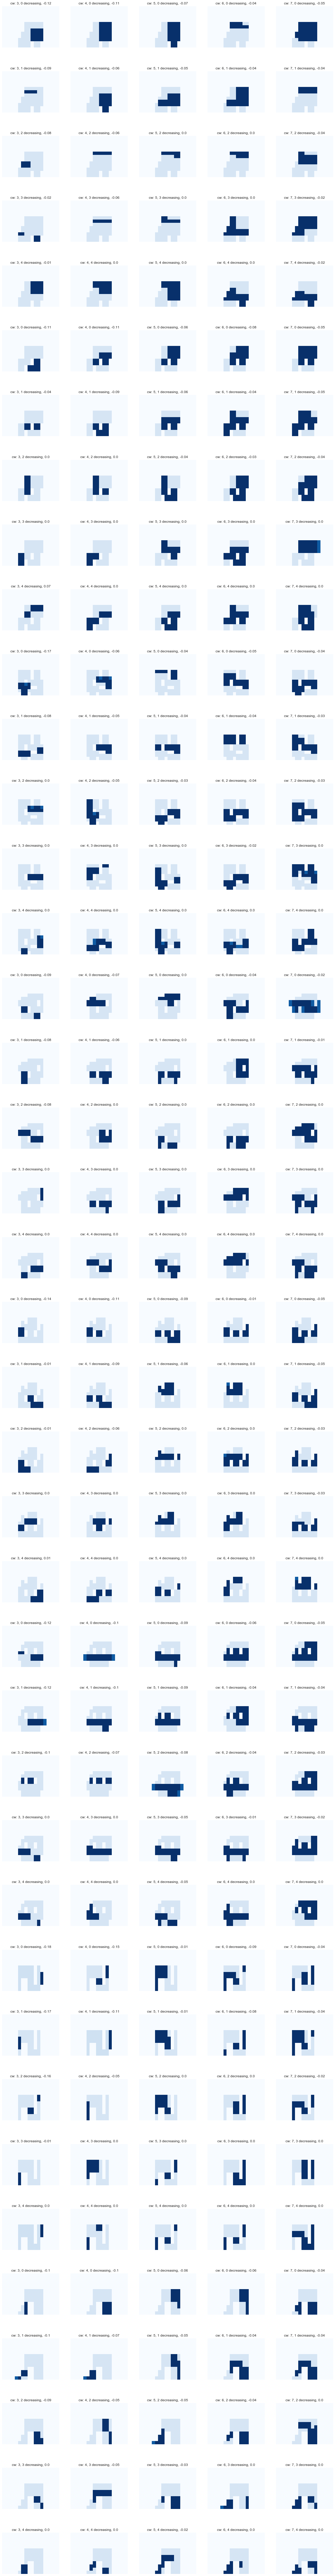

In [327]:
# plot chunks of highest decrease

nchunks = 5

fig, axs = plt.subplots(len(targets)*nchunks, len(window_sizes), figsize=(4*len(window_sizes),4*len(targets)*nchunks))

for i, target in enumerate(targets):
    for j, chunk_window in enumerate(window_sizes):
        
        df_subset = df_pivot[(df_pivot.targetName==target) & (df_pivot.chunk_window==chunk_window)]
        
        #for ascending in [True, False]:
        
        df_subset_sorted = df_subset.sort_values(by='diff', ascending=True).reset_index()

        for k in range(0,nchunks):
            chunk = df_subset_sorted.loc[k,'chunk']
            drawing.show_chunk([chunk], axs[i*nchunks+k,j], target=target)
            axs[i*nchunks+k,j].set_title('cw: ' + str(chunk_window) + ', ' + str(k) + ' decreasing, '  + str(round(df_subset_sorted.loc[k,'diff'],2)))
            axs[i*nchunks+k,j].axis('off')
            

#### frequency of chunk appearance

rank = popularity of chunk in perfect reconstructions. I.e. rank=0 means the most popular chunk

/Users/will/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 720x432 with 0 Axes>

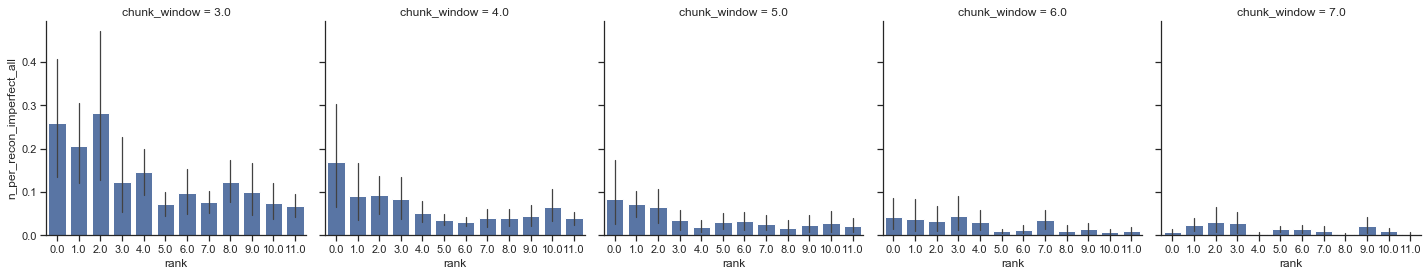

In [191]:
# How often were most popular chunks used in imperfect reconstructions?

fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
g = sns.FacetGrid(df_top_chunks, col="chunk_window", height=4)
g.map(sns.barplot, "rank", "n_per_recon_imperfect_all");
# g.map(sns.pointplot, "rank","num_imperfect_post", color='orange');

/Users/will/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 720x432 with 0 Axes>

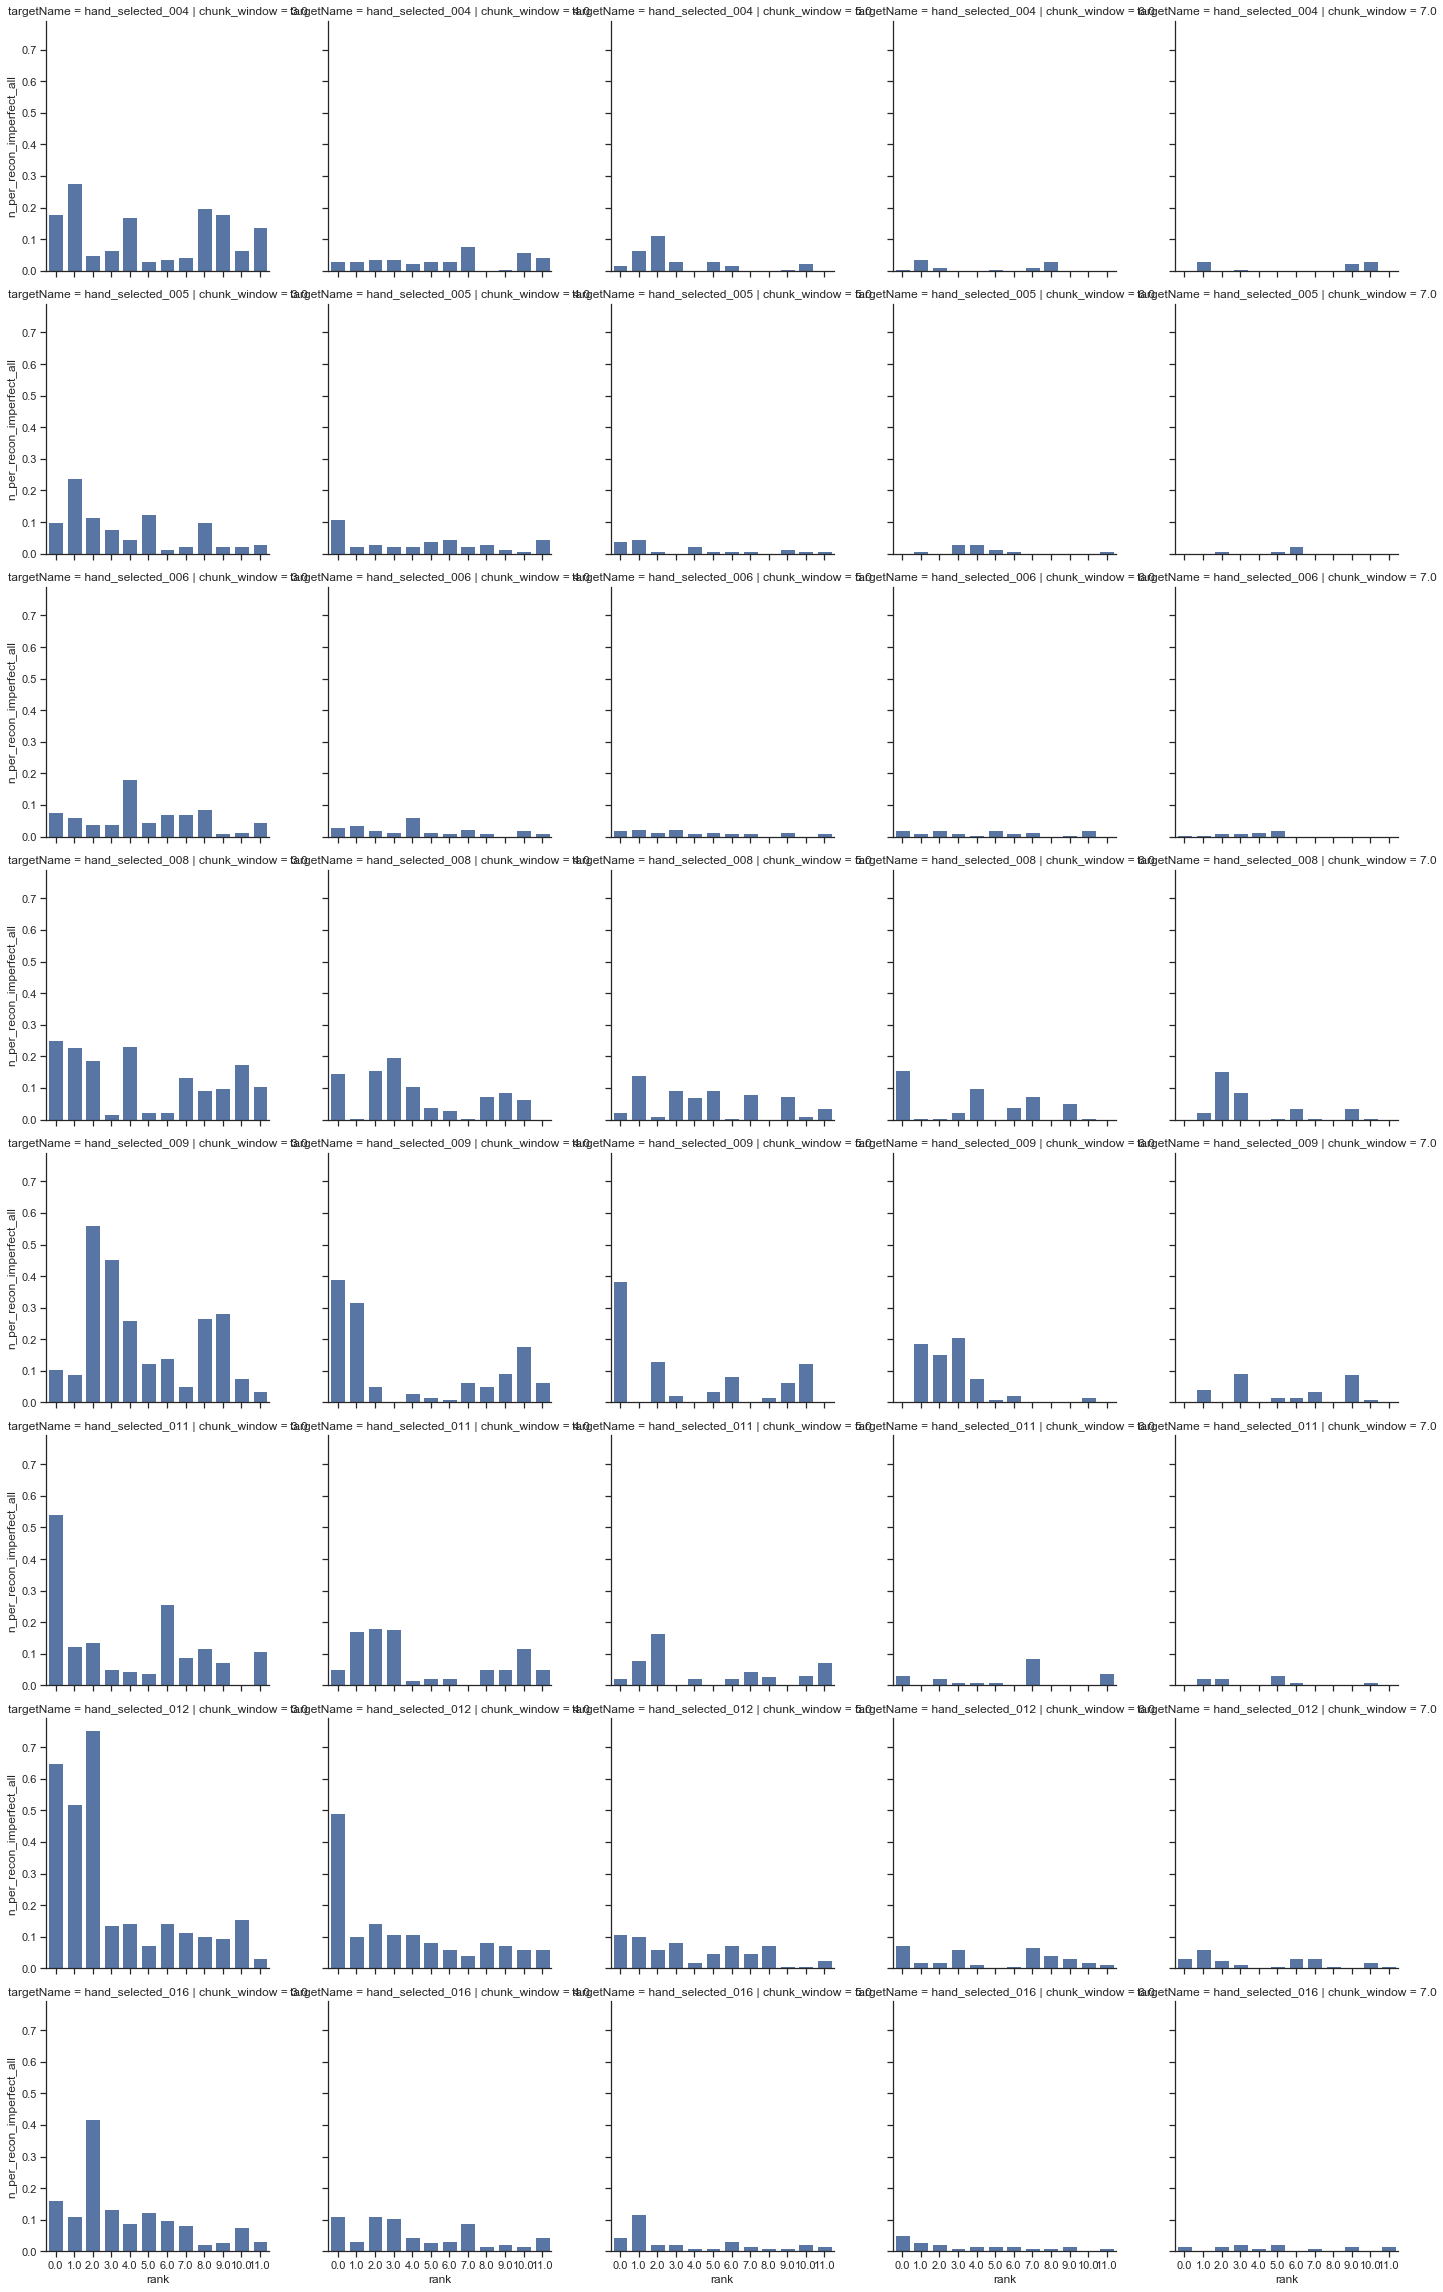

In [192]:
# How often were most popular chunks used in imperfect reconstructions?

fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
g = sns.FacetGrid(df_top_chunks, col="chunk_window", row="targetName", height=4)
g.map(sns.barplot, "rank", "n_per_recon_imperfect_all");
# g.map(sns.pointplot, "rank","num_imperfect_post", color='orange');

<Figure size 720x432 with 0 Axes>

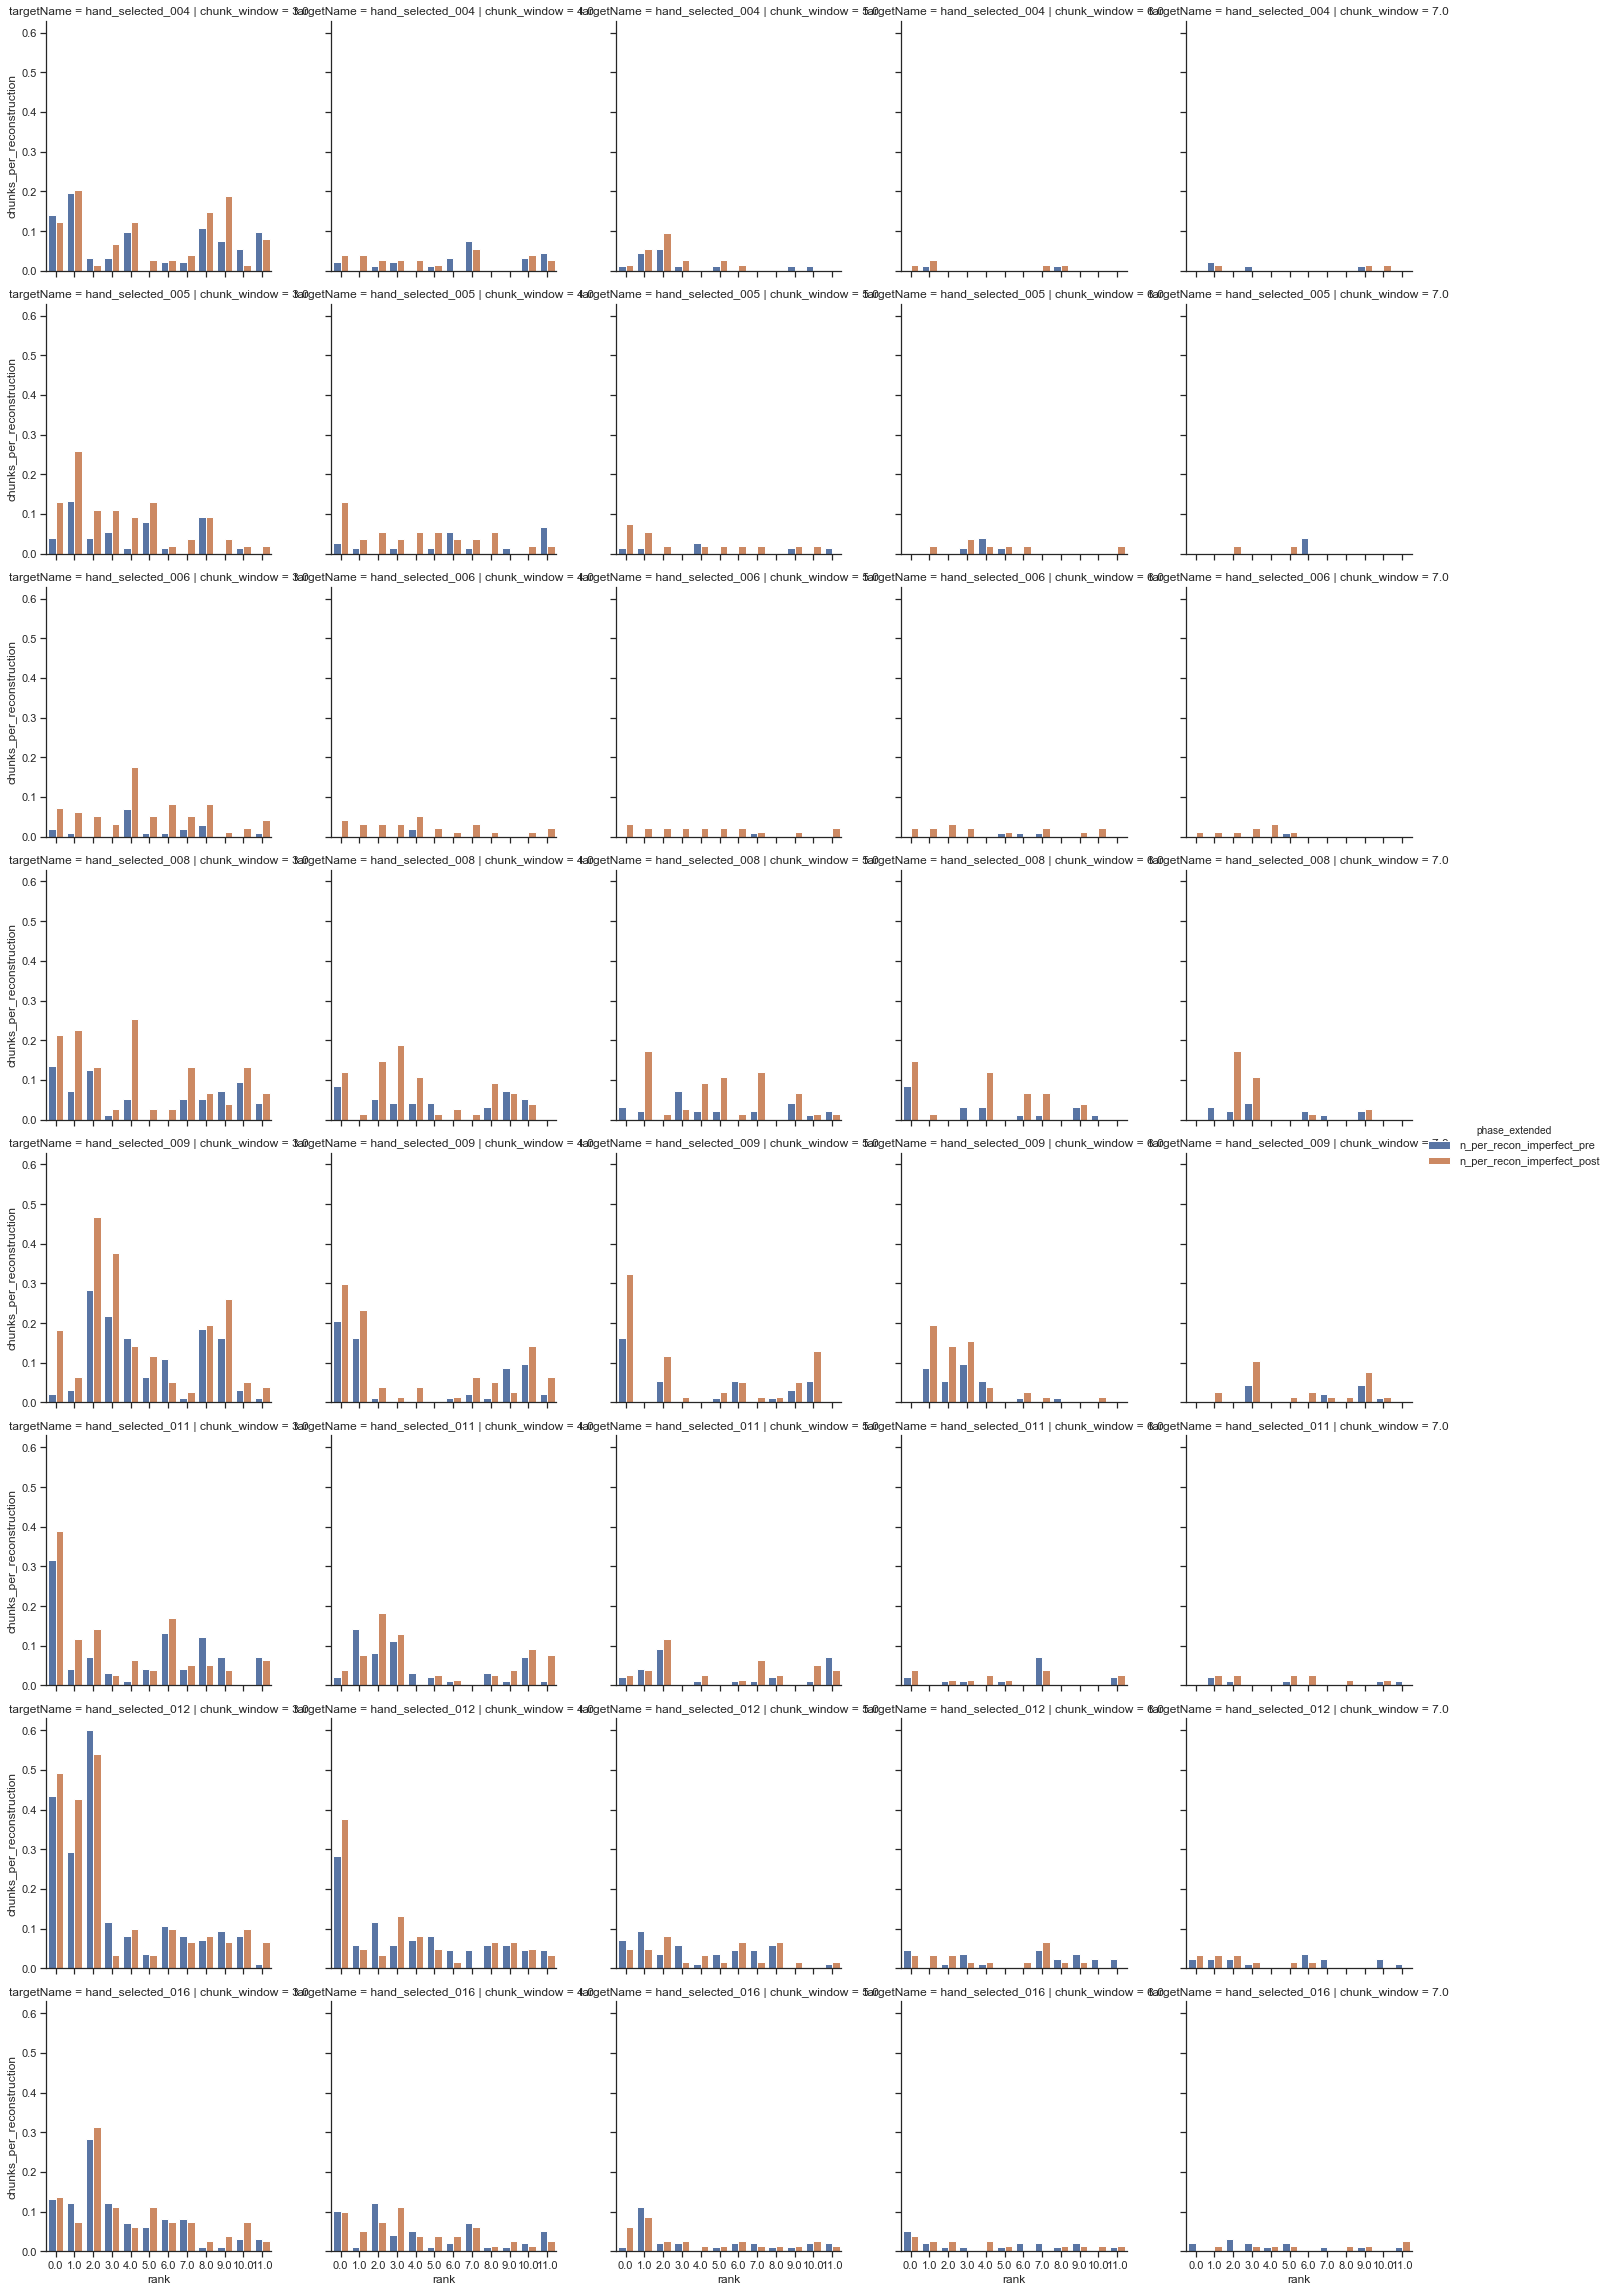

In [193]:
# How often were most popular chunks used in imperfect reconstructions, by phase?

df_top_chunks_pivot = df_top_chunks.melt(id_vars=['chunk_window',
                                                    'targetName',
                                                    'rank',
                                                  #'imperfect_count',
                                                    ],
                                           value_vars=['n_per_recon_imperfect_pre', 'n_per_recon_imperfect_post'],
                                           var_name='phase_extended', value_name='chunks_per_reconstruction')

fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})

sns.catplot(data=df_top_chunks_pivot, 
            x='rank', 
            y='chunks_per_reconstruction', 
            col="chunk_window", 
            row="targetName", 
            hue="phase_extended", 
            height=4, 
            kind='bar', 
            hue_order=['n_per_recon_imperfect_pre', 'n_per_recon_imperfect_post'])

<Figure size 720x432 with 0 Axes>

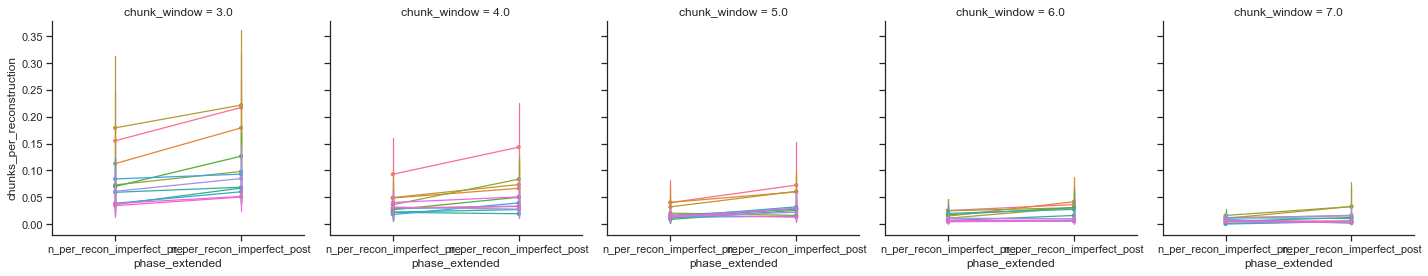

In [194]:
# How often were most popular chunks used in imperfect reconstructions, by phase?
# Here, each line is a chunk identified in from all perfect reconstructions (of a tower).
# They seem to be built more often in post.

fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
g = sns.FacetGrid(df_top_chunks_pivot, col="chunk_window", col_wrap=5, height=4, hue='rank')
g.map(sns.pointplot, "phase_extended","chunks_per_reconstruction", order=['n_per_recon_imperfect_pre','n_per_recon_imperfect_post']);

<Figure size 1008x720 with 0 Axes>

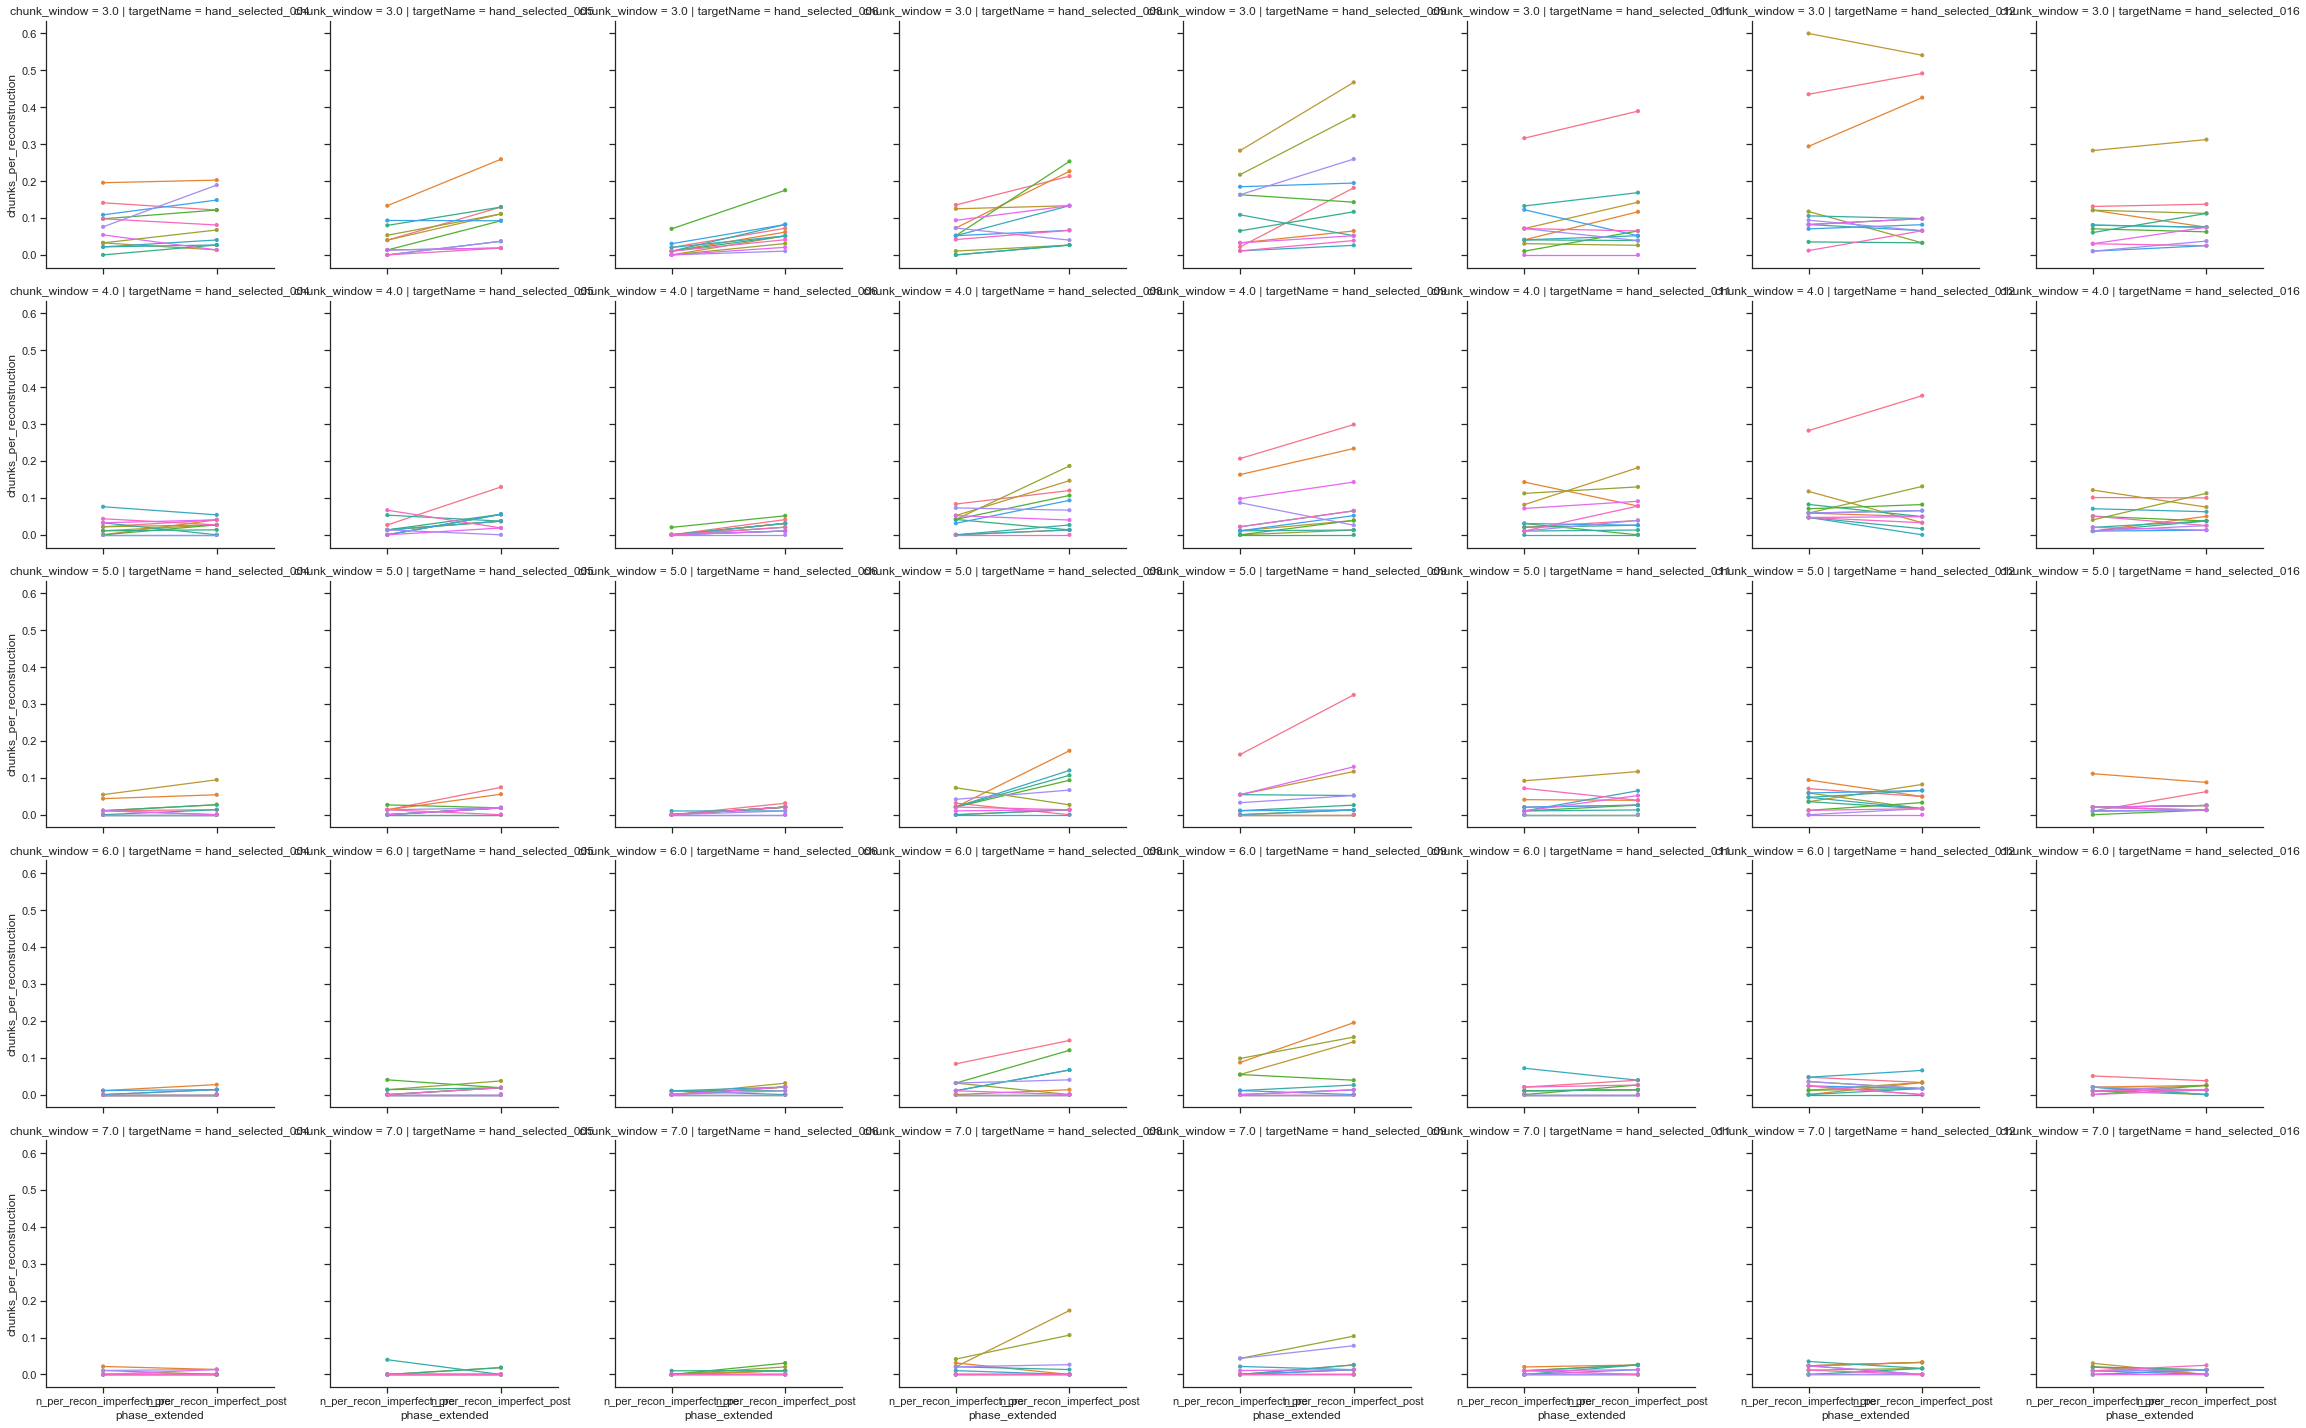

In [195]:
# How often were most popular chunks used in imperfect reconstructions, by phase?
# Here, each line is a chunk identified in from all perfect reconstructions (of a tower).
# They seem to be built more often in post.

fig = plt.figure(figsize=(14,10))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
g = sns.FacetGrid(df_top_chunks_pivot, col="targetName", row="chunk_window", hue='rank', height=4, col_order=targets)
g.map(sns.pointplot, "phase_extended", "chunks_per_reconstruction", order=['n_per_recon_imperfect_pre','n_per_recon_imperfect_post'])



In [ ]:
df_chunks = compute_all_chunks(window_sizes)

## Old analysis using perfect reconstructions

#### Identify most frequently built chunks from *perfect reconstructions only*

In [189]:
top_chunks_perfect = find_popular_chunks(dfic[dfic.perfectScore],
                                         window_sizes = window_sizes,
                                         n_chunks=n_top_chunks)

#### For each popular chunk in perfect reconstructions, find all imperfect reconstructions containing that chunk and summarize info in a new dataframe 

In [21]:
# Iterate over the 10 most popular chunks in all perfect reconstructions.
# Searches for each of these chunks in all of the imperfect reconstructions
# Calculate proportion of imperfect reconstructions (of that particular structure) that contain that chunk

df_top_chunks = pd.DataFrame()

df_top_chunks_recons = pd.DataFrame()

for chunk_window in window_sizes:
    
    for target in targets:
        
        n_imp_recons_pre = df_chunks[(df_chunks.phase_extended=='pre') & (df_chunks.perfectScore==False) & (df_chunks.targetName==target)].shape[0]
        n_imp_recons_post = df_chunks[(df_chunks.phase_extended=='post') & (df_chunks.perfectScore==False) & (df_chunks.targetName==target)].shape[0]

        for rank in range(n_top_chunks):

            # get the chunk
            chunk_item = list(top_chunks_perfect[chunk_window][target]['top_k_diff'])[rank]
            chunk = chunk_item[0] # [0] gets the chunk, [1] gets the count
            imperfect_count = chunk_item[1]
            
            # grab only structures with that chunk
            subset_with_chunk = df_chunks[(~df_chunks.perfectScore) & 
                                          (df_chunks.targetName == target) & 
                                          (df_chunks[str(chunk_window)+'_chunks'].apply(lambda chunks: chunk in chunks))]

#             top_chunks[chunk_window][target]['num_imperfect'][rank] = subset_with_chunk.shape[0]
#             top_chunks[chunk_window][target]['mean_F1'][rank] = np.mean(subset_with_chunk.rawF1DiscreteScore)
            
            df_top_chunks = df_top_chunks.append({
                'targetName' : target,
                'chunk_window' : chunk_window,
                'n_imp_recons_pre' : n_imp_recons_pre,
                'n_imp_recons_post' : n_imp_recons_post,
                'rank' : rank,
                'chunk' : chunk,
                'imperfect_count': imperfect_count,
                'num_imperfect_all' : subset_with_chunk.shape[0],
                'num_imperfect_pre' : subset_with_chunk[subset_with_chunk.phase_extended=='pre'].shape[0],
                'num_imperfect_post' : subset_with_chunk[subset_with_chunk.phase_extended=='post'].shape[0],
                'n_per_recon_imperfect_all':  subset_with_chunk.shape[0]/(n_imp_recons_pre+n_imp_recons_post),
                'n_per_recon_imperfect_pre' : subset_with_chunk[subset_with_chunk.phase_extended=='pre'].shape[0]/n_imp_recons_pre,
                'n_per_recon_imperfect_post' : subset_with_chunk[subset_with_chunk.phase_extended=='post'].shape[0]/n_imp_recons_post,
                'n_per_recon_imperfect_diff' : (subset_with_chunk[subset_with_chunk.phase_extended=='post'].shape[0]/n_imp_recons_post)-(subset_with_chunk[subset_with_chunk.phase_extended=='pre'].shape[0]/n_imp_recons_pre),
                'mean_F1' : np.mean(subset_with_chunk.rawF1DiscreteScore),
                'mean_F1_pre' : np.mean(subset_with_chunk[subset_with_chunk.phase_extended=='pre'].rawF1DiscreteScore),
                'mean_F1_post' : np.mean(subset_with_chunk[subset_with_chunk.phase_extended=='post'].rawF1DiscreteScore),
                'std_F1' : np.std(subset_with_chunk.rawF1DiscreteScore),
            }, ignore_index=True)
        

NameError: name 'top_chunks_perfect' is not defined

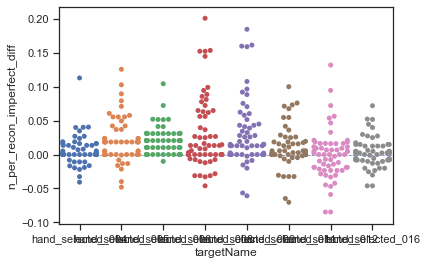

In [196]:
p = sns.swarmplot(y='n_per_recon_imperfect_diff', x='targetName', data=df_top_chunks, dodge=True)
ax = p.axes
ax.axhline(0, ls='--')

In [109]:
df_top_chunks[(df_top_chunks.n_per_recon_imperfect_diff < 0)].shape[0]

82

In [112]:
df_top_chunks[(df_top_chunks.n_per_recon_imperfect_diff == 0)].shape[0]

75

In [111]:
df_top_chunks[(df_top_chunks.n_per_recon_imperfect_diff > 0)].shape[0]

243

In [297]:
def draw_row_chunk(row, axs):
    axs[row.name].axis('off')
    chunk = row.chunk
    drawing.show_chunk([chunk], axs[row.name], target=row.targetName)

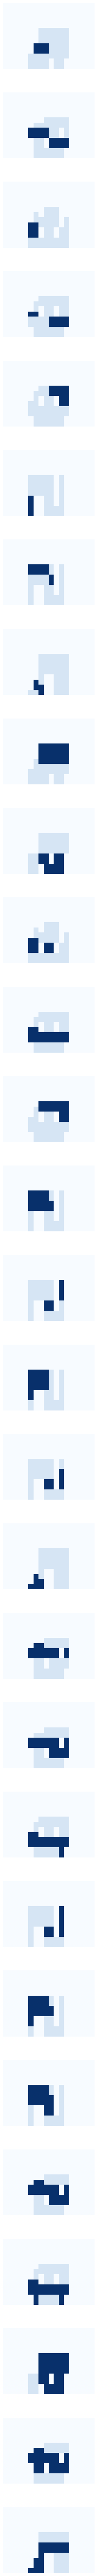

In [298]:
# show chunks built less over time 
df_negative_diffs = df_top_chunks[(df_top_chunks.n_per_recon_imperfect_diff < -0.03)].reset_index()
n_chunks = df_negative_diffs.shape[0]
fig, axs = plt.subplots(n_chunks, figsize=(4,n_chunks*4)) 

_ = df_negative_diffs.apply(lambda row: draw_row_chunk(row, axs), axis=1)


#### Mean accuracy of reconstructions containing popular chunks

/Users/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resultiing Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  import sys


<Figure size 720x432 with 0 Axes>

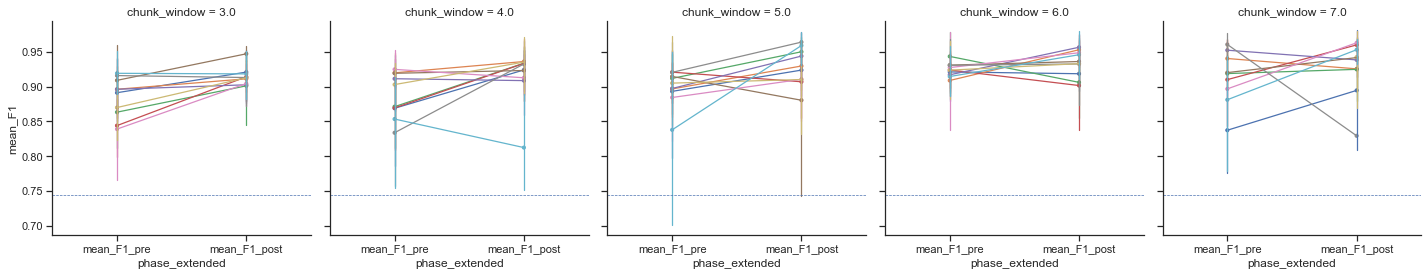

In [30]:
# Mean accuracy of reconstructions containing popular chunks, averaged across all targets

df_top_chunks_pivot = df_top_chunks.melt(id_vars=['chunk_window',
                                                    'targetName',
                                                    'rank'],
                                           value_vars=['mean_F1_pre', 'mean_F1_post'],
                                           var_name='phase_extended', value_name='mean_F1')

fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})
g = sns.FacetGrid(df_top_chunks_pivot, col="chunk_window", col_wrap=5, height=4, hue='rank')
g.map(sns.pointplot, "phase_extended","mean_F1", order=['mean_F1_pre', 'mean_F1_post']);

for ax in g.axes:
    mean_acc = np.mean(df_chunks[(~df_chunks.perfectScore)]['rawF1DiscreteScore'])
    ax.axhline(mean_acc, ls='--')

/Users/will/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resultiing Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  


<Figure size 720x432 with 0 Axes>

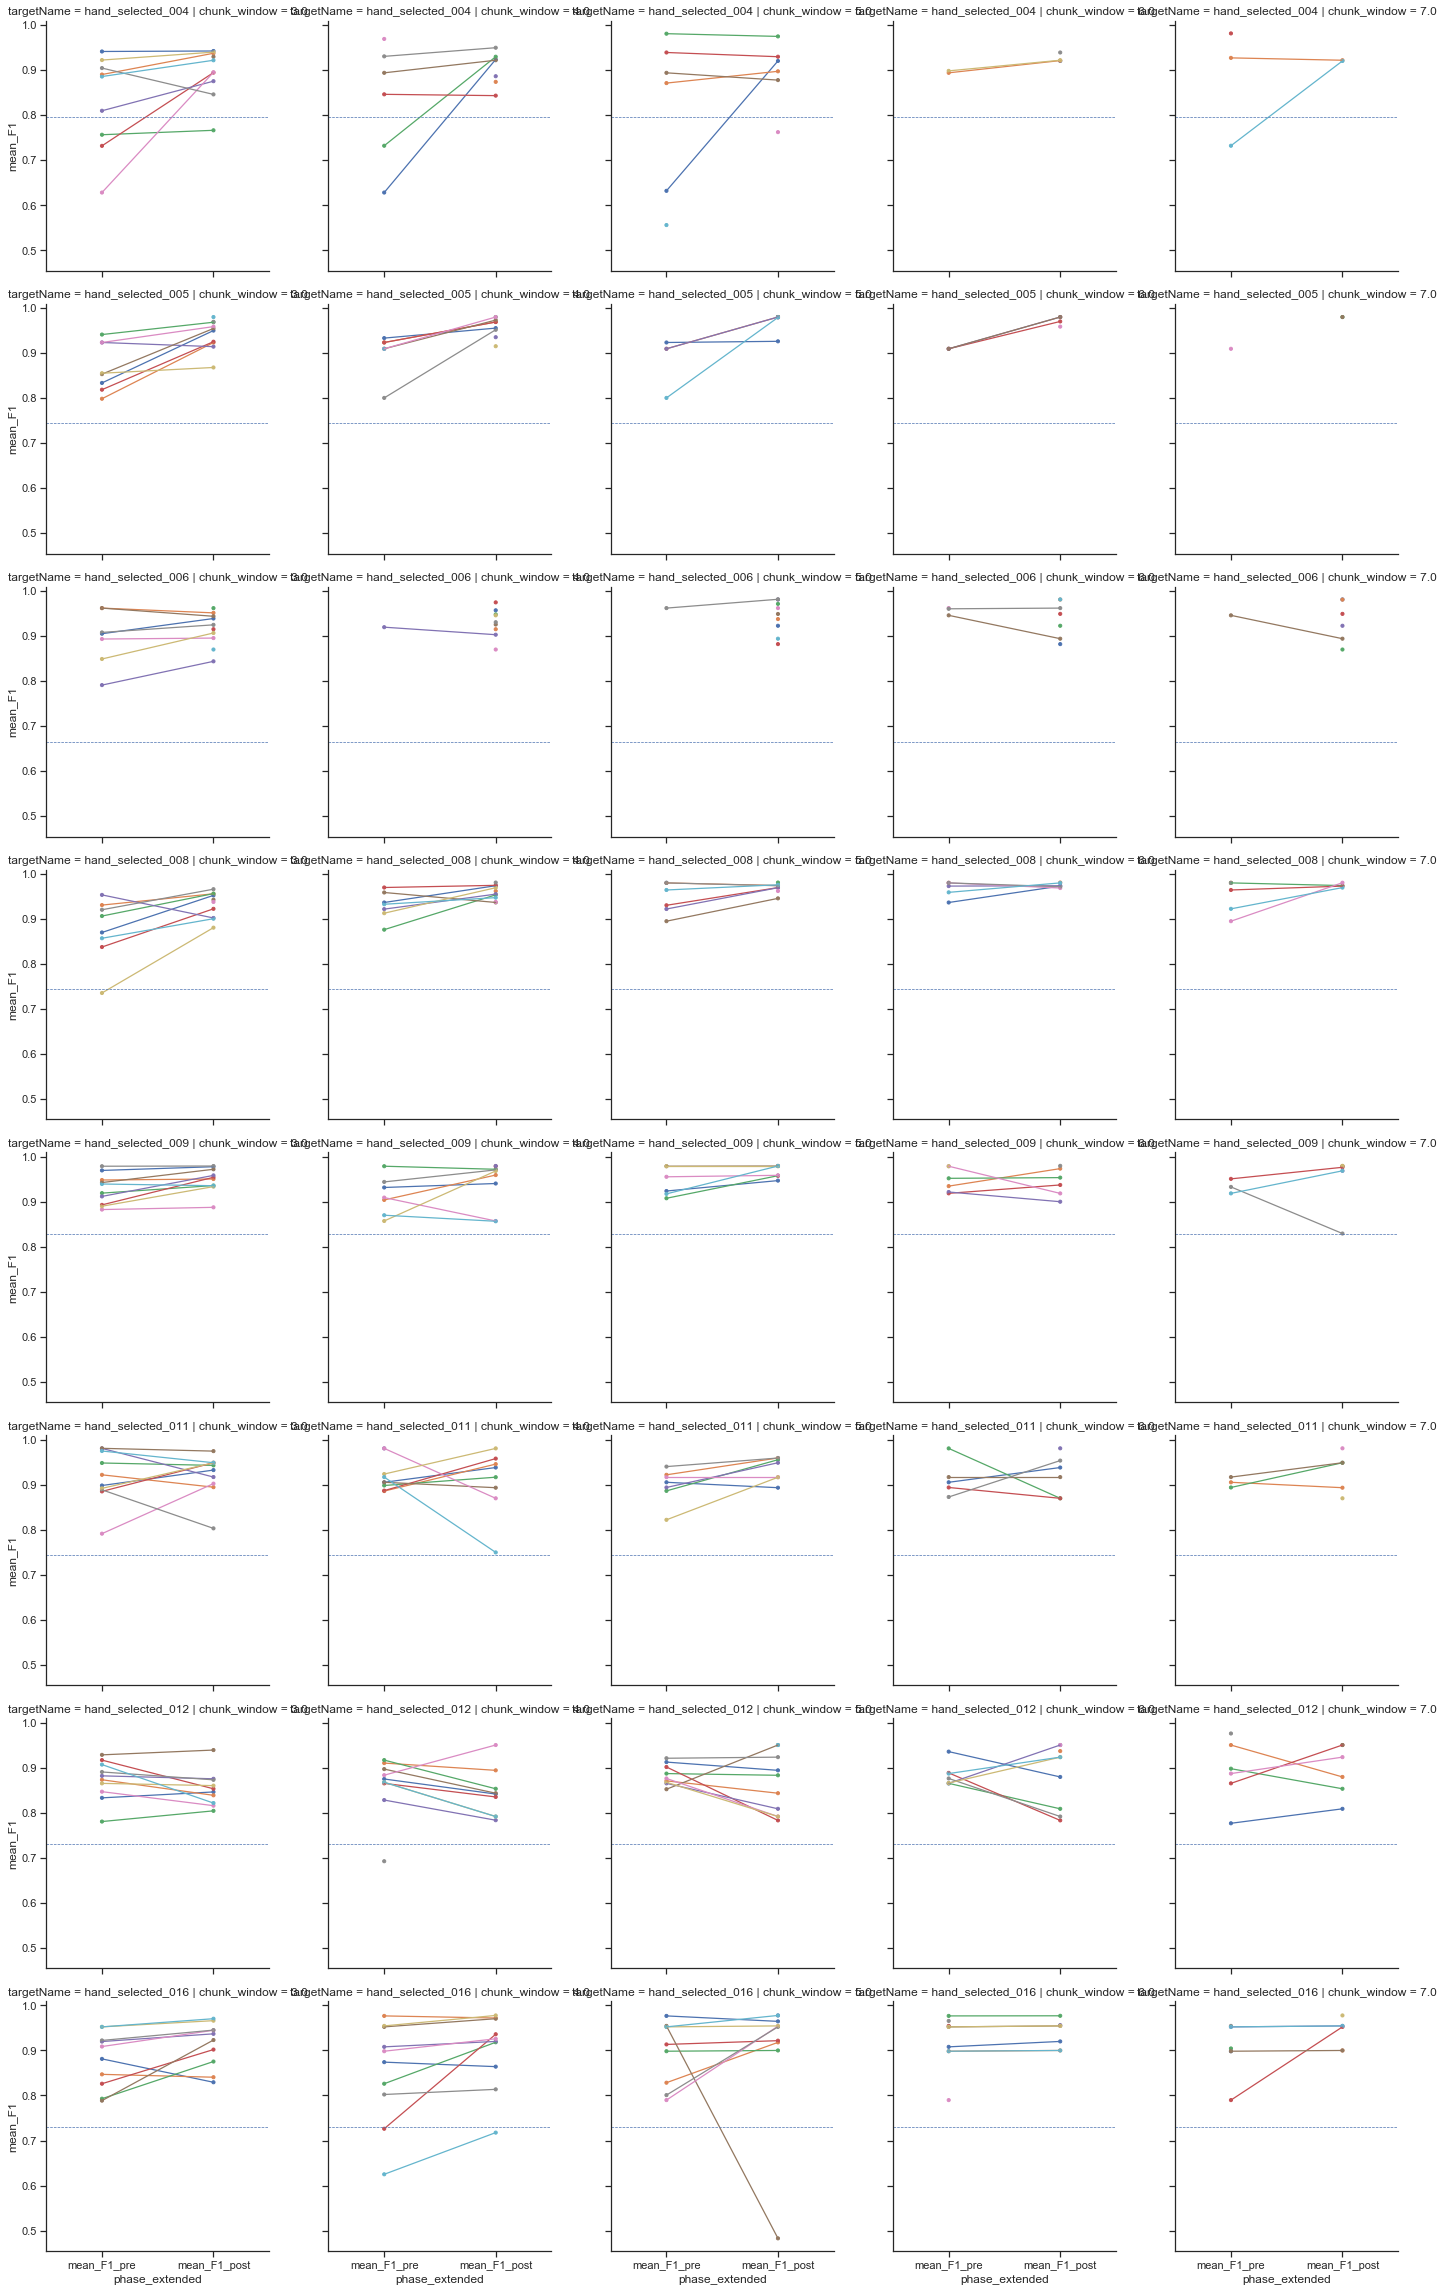

In [31]:
# Mean accuracy of reconstructions containing popular chunks, by structure
# Horizontal lines are mean accuracy of all imperfect reconstructions (those with AND without the chunk)

df_top_chunks_pivot = df_top_chunks.melt(id_vars=['chunk_window',
                                                    'targetName',
                                                    'rank'],
                                           value_vars=['mean_F1_pre', 'mean_F1_post'],
                                           var_name='phase_extended', value_name='mean_F1')

fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend':False})
sns.set(style="ticks", rc={"lines.linewidth": 0.7})

g = sns.FacetGrid(df_top_chunks_pivot, col="chunk_window", row="targetName", height=4, hue='rank')
g.map(sns.pointplot, "phase_extended","mean_F1", order=['mean_F1_pre', 'mean_F1_post']);

for target_i, axes in enumerate(g.axes):
    for ax in axes:
        mean_acc = np.mean(df_chunks[(~df_chunks.perfectScore) & 
                          (df_chunks.targetName == targets[target_i])]['rawF1DiscreteScore'])
        ax.axhline(mean_acc, ls='--')